# ADC Peaks of an specific channel

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.ticker as ticker

dead_channels = {0, 37, 38, 75, 76, 113, 114, 151}
calibration_channels = {19, 57, 95, 133}
notConnected_channels = {9, 18, 28, 47, 56, 66, 85, 94, 104, 123, 132, 142}

# ========= To make the plots =========
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h', 'X', '1', '2', '3', '4', '|']

color_list = [
    "#e6194b",  # Red
    "#3cb44b",  # Green
    "#ffe119",  # Yellow
    "#4363d8",  # Blue
    "#f58231",  # Orange
    "#911eb4",  # Purple
    "#46f0f0",  # Cyan
    "#f032e6",  # Magenta
    "#bcf60c",  # Lime
    "#008080",  # Teal
    "#9a6324",  # Brown
    "#800000",  # Maroon
    "#808000",  # Olive
    "#000075",  # Navy
    "#a9a9a9",  # Dark Gray
    "#ff4500",  # Orange Red
    "#228b22",  # Forest Green
    "#1e90ff",  # Dodger Blue
    "#8b008b",  # Dark Magenta
]

num_groups = 8
files_per_group = 19

# === Configuration for ADC===
CONFIG = { 
    # "base_path": "/home/eic/Documents/internalinjection/PedestalStudies_InternalInjection_Oct2025/Linearity_Studies_Nov2025", 
    "base_path": "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025", 
    "amplitudes": [100, 200, 300, 400], 
    "fpga_pb_pairs": [
        ("208", "06"),
        ("209", "008")
    ],
    "runs": 5
}

# === Configuration for ToT ===
CONFIG_TOT = { 
    # "base_path": "/home/eic/Documents/internalinjection/PedestalStudies_InternalInjection_Oct2025/Linearity_Studies_Nov2025", 
    "base_path": "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025", 
    "amplitudes": [400, 450, 925, 1450, 1975], 
    "fpga_pb_pairs": [
        ("208", "06"),
        ("209", "008")
    ],
    "runs": 5
}

# ========= Load pedestal CSV and build channel → pedestal map =========
PEDESTAL_CSV = "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/pedestals/pedestals_HV_modified_FPGA208_209.csv"

# fallback pedestal if a channel has no entry in the CSV
fallback_pedestal = 80

# ========= Load pedestal CSV and build channel → pedestal map =========
ped_df = pd.read_csv(PEDESTAL_CSV)

##########################
## For ADC FPGA per run ##
##########################

# ========= Choices ADC plot per run =========
pair_id = 0                 # 0 → (208,06), 1 → (209,008)
injected_amplitude = 400    # amplitude to plot
run_number = 2              # 1–5

# ========= Extract FPGA–PB pair from CONFIG =========
fpga_adc, pb_adc = CONFIG["fpga_pb_pairs"][pair_id]
fpga_int = int(fpga_adc)
pb_int   = int(pb_adc)   # "06" → 6, "008" → 8
run_idx = run_number - 1     # convert to index

pair_key = f"fpga{fpga_adc}_pb{pb_adc}"

ped_sub = ped_df[(ped_df["FPGA"] == fpga_int) & (ped_df["PB"] == pb_int)]
# Build dict: channel -> pedestal (HV)
pedestal_map = ped_sub.set_index("Channel")["HV"].to_dict()

print(f"Loaded {len(pedestal_map)} pedestal values for FPGA {fpga_int}, PB {pb_int}")


#############################################################
## For mean ADC FPGA plot (also used in linearity analysis)##
#############################################################

# ========= User choices =========
pair_id_mean = 0              # 0 → (208,06), 1 → (209,008)
injected_amplitude_mean = 400  # amplitude to plot (must be in CONFIG["amplitudes"])

# ========= Get FPGA–PB pair from CONFIG =========
fpga_adc_mean, pb_adc_mean = CONFIG["fpga_pb_pairs"][pair_id_mean]   # e.g. ("208", "06")

fpga_int_mean = int(fpga_adc_mean)
pb_int_mean   = int(pb_adc_mean)   # "06" → 6, "008" → 8

pair_key_mean = f"fpga{fpga_adc_mean}_pb{pb_adc_mean}"

ped_sub_mean = ped_df[(ped_df["FPGA"] == fpga_int_mean) & (ped_df["PB"] == pb_int_mean)]
# Build dict: channel -> pedestal (HV)
pedestal_map_mean = ped_sub_mean.set_index("Channel")["HV"].to_dict()

print(f"Loaded {len(pedestal_map_mean)} pedestal values for FPGA {fpga_int_mean}, PB {pb_int_mean}")




Loaded 144 pedestal values for FPGA 208, PB 6
Loaded 144 pedestal values for FPGA 208, PB 6


### ADC Directory Test

In [2]:
# === Directory Generator Function ===
def generate_all_dirs(config):
    all_dirs = {}
    
    for fpga, pb in config["fpga_pb_pairs"]:
        pair_key = f"fpga{fpga}_pb{pb}"
        all_dirs[pair_key] = {}
        
        for amp in config["amplitudes"]:
            all_dirs[pair_key][amp] = {
                i: f'{config["base_path"]}/{amp}dac/inj_adc_samples_{fpga}_pb{pb}_76_{amp}_{i+1}.csv'
                for i in range(config["runs"])
            }
            
    return all_dirs

# === Initialize Directories ===
all_dirs = generate_all_dirs(CONFIG)

# === Utility Functions ===
def get_path(fpga, pb, amplitude, run, dirs_dict=all_dirs):
    pair_key = f"fpga{fpga}_pb{pb}"
    try:
        return dirs_dict[pair_key][amplitude][run]
    except KeyError:
        raise ValueError(f"No path found for pair ({fpga}, {pb}), amplitude {amplitude}, and run {run}")

def list_all_paths(dirs_dict=all_dirs):
    return [
        path 
        for pair_dirs in dirs_dict.values()
        for amp_dirs in pair_dirs.values()
        for path in amp_dirs.values()
    ]

# # === Example: Print All Paths ===
# for path in list_all_paths():
#     print(path)

# # Show dictionary structure
# all_dirs


### ToT Directory Test

In [3]:
# === Directory Generator Function for ToT ===
def generate_all_dirs_tot(config):
    all_dirs = {}
    
    for fpga, pb in config["fpga_pb_pairs"]:
        pair_key = f"fpga{fpga}_pb{pb}"
        all_dirs[pair_key] = {}
        
        for amp in config["amplitudes"]:
            all_dirs[pair_key][amp] = {
                i: f'{config["base_path"]}/{amp}dac/inj_adc_samples_{fpga}_pb{pb}_76_{amp}_{i+1}.csv'
                for i in range(config["runs"])
            }
            
    return all_dirs

# === Initialize Directories ===
all_dirs_tot = generate_all_dirs_tot(CONFIG_TOT)

# === Utility Functions ===
def get_path_tot(fpga, pb, amplitude, run, dirs_dict=all_dirs_tot):
    pair_key = f"fpga{fpga}_pb{pb}"
    try:
        return dirs_dict[pair_key][amplitude][run]
    except KeyError:
        raise ValueError(f"No path found for pair ({fpga}, {pb}), amplitude {amplitude}, and run {run}")

def list_all_paths_tot(dirs_dict=all_dirs_tot):
    return [
        path 
        for pair_dirs in dirs_dict.values()
        for amp_dirs in pair_dirs.values()
        for path in amp_dirs.values()
    ]

# # === Example: Print All ToT Paths ===
# for path in list_all_paths_tot():
#     print(path)

# # Show dictionary structure
# all_dirs_tot

## Plot the waveform in all connected channels

Using file:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/400dac/inj_adc_samples_208_pb06_76_400_2.csv


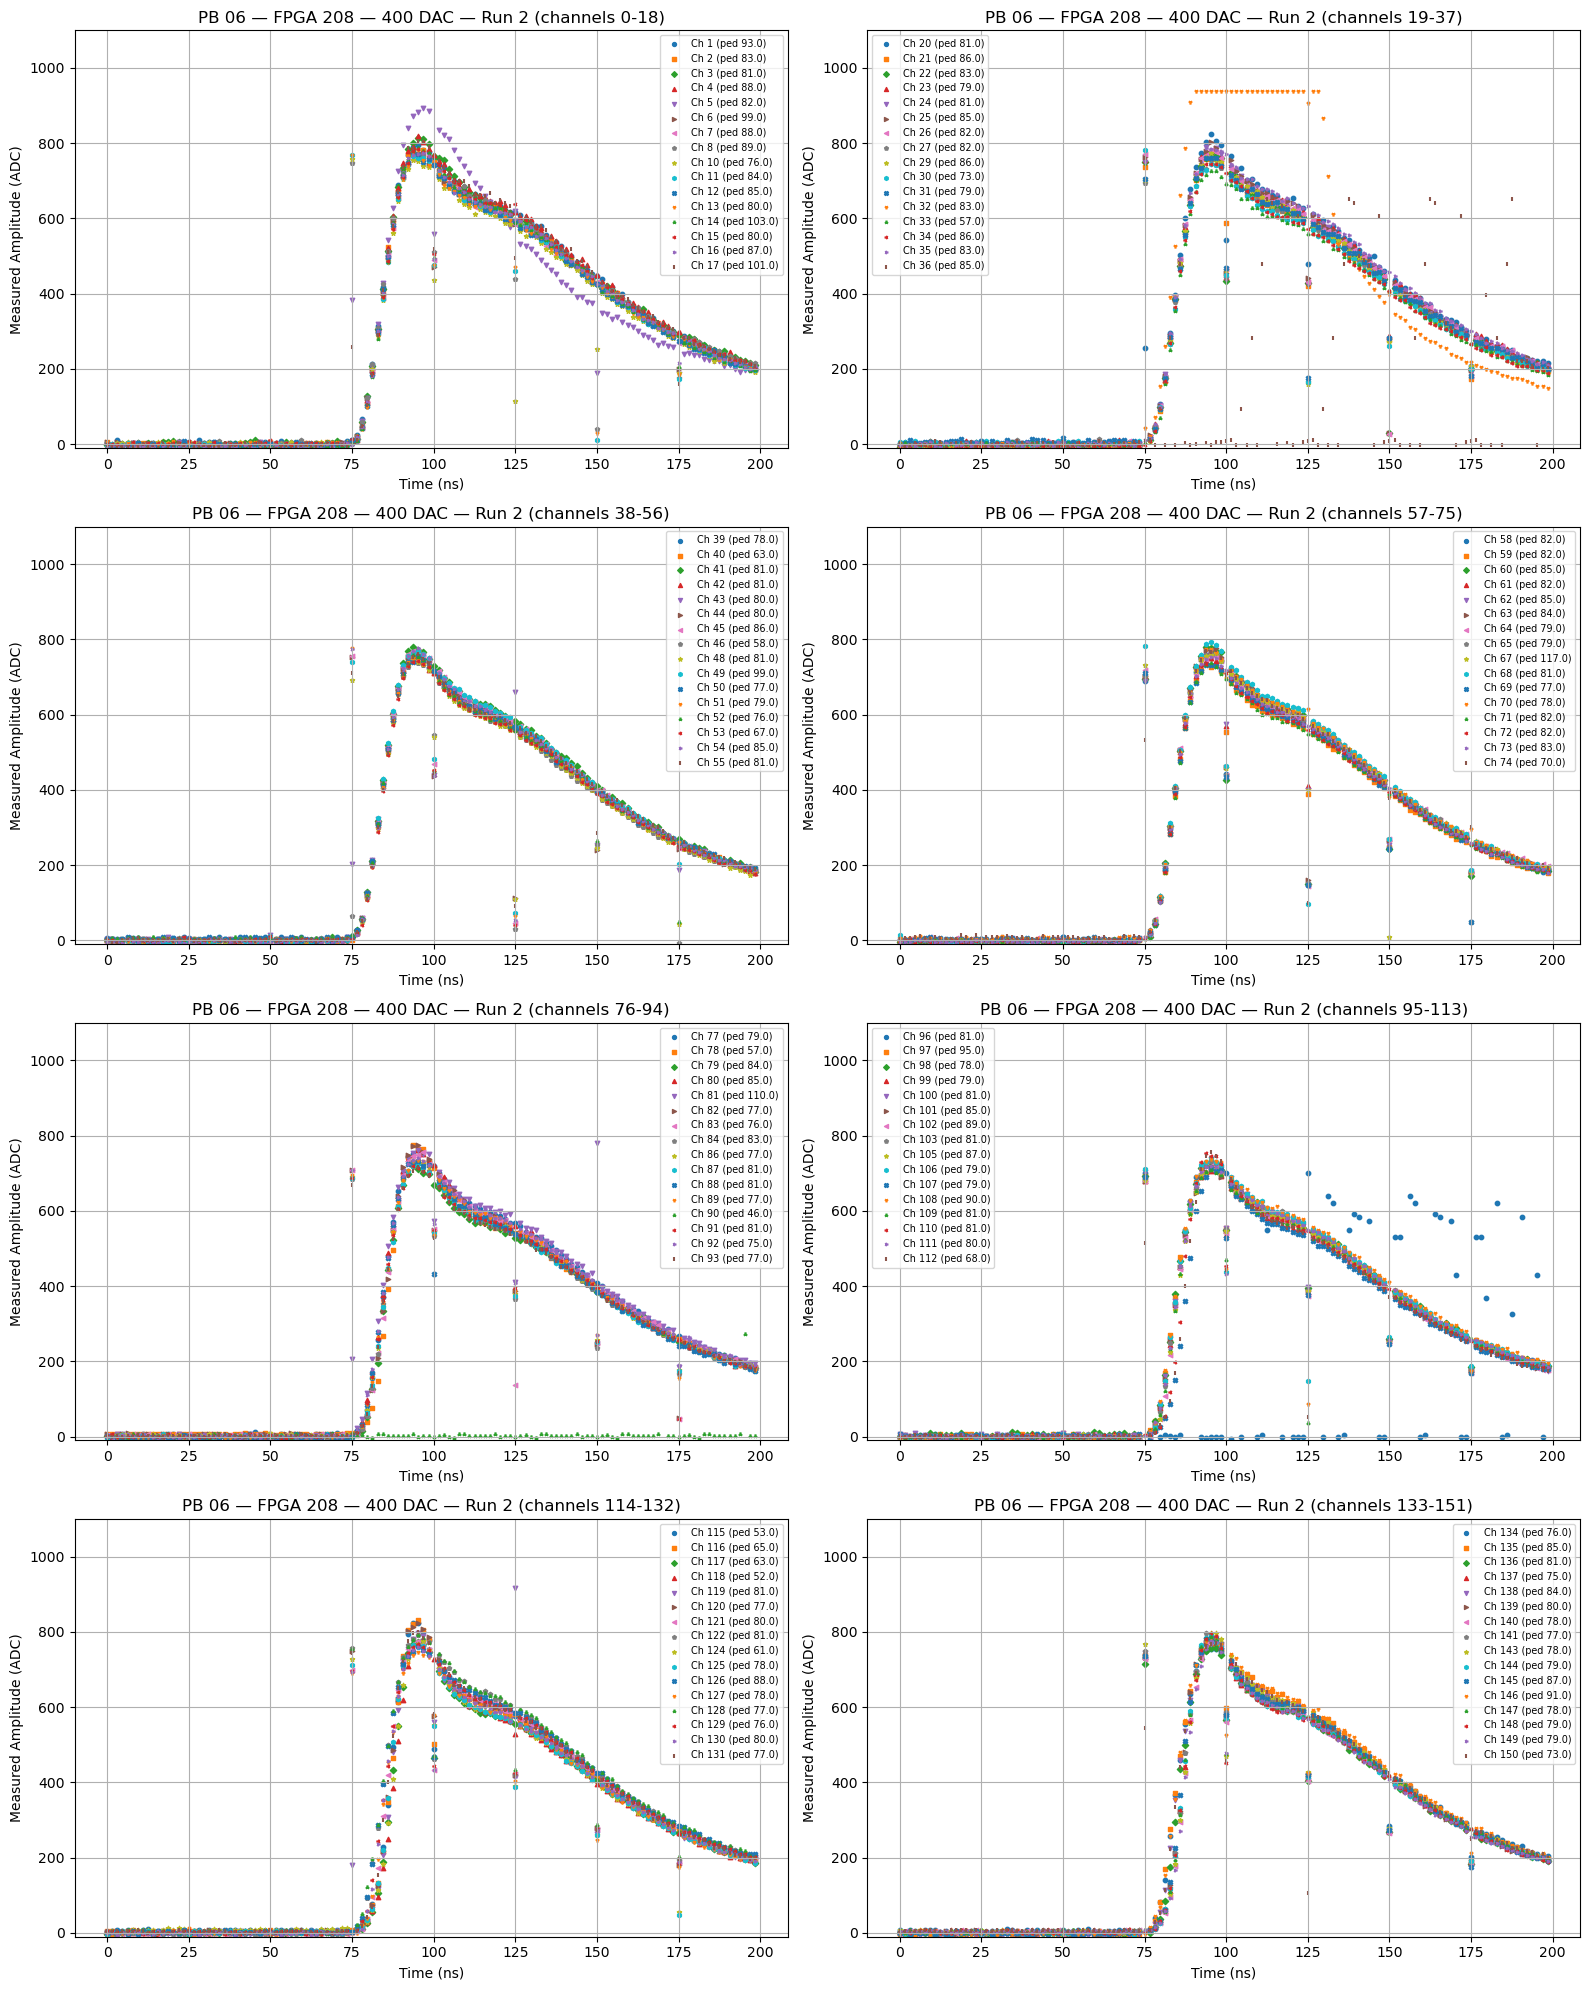

Figure saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_208_pb06/phases_fpga208-pb06_amp400_run2.png


In [4]:
# ========= Retrieve file =========
try:
    data_file = all_dirs[pair_key][injected_amplitude][run_idx]
except KeyError:
    print(f"No entry in all_dirs for {pair_key}, amplitude {injected_amplitude}, run {run_number}")
    raise

if not os.path.exists(data_file):
    print(f"File not found:\n{data_file}")
    raise SystemExit

print(f"Using file:\n  {data_file}")

# ========= Plotting code =========

fig, axs = plt.subplots(4, 2, figsize=(16, 20))
axs = axs.flatten()

df = pd.read_csv(data_file)
df.columns = df.columns.str.strip()


for group_id in range(num_groups):
    ax = axs[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group
    marker_index = 0

    for i in range(first_channel, last_channel):
        if i in dead_channels or i in calibration_channels or i in notConnected_channels:
            continue

        channel_data = df[df['Channel'] == i]
        if channel_data.empty:
            continue
        
        # Get pedestal for this channel
        ped_i = pedestal_map.get(i, fallback_pedestal)

        
        ax.scatter(
            channel_data['Time'],
            channel_data['ADC'] - ped_i,
            label=f'Ch {i} (ped {ped_i:.1f})',
            marker=markers[marker_index % len(markers)],
            s=10
        )
        marker_index += 1

    ax.set_title(
        f'PB {pb_adc} — FPGA {fpga_adc} — {injected_amplitude} DAC — Run {run_number} '
        f'(channels {first_channel}-{last_channel-1})'
    )
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Measured Amplitude (ADC)')
    ax.set_ylim(-10, 1100)
    ax.grid(True)
    ax.legend(fontsize='x-small', markerscale=0.9)

plt.tight_layout()
plt.show()

# ========= Save figure =========
output_dir = f'/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_adc}_pb{pb_adc}'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(
    output_dir,
    f'phases_fpga{fpga_adc}-pb{pb_adc}_amp{injected_amplitude}_run{run_number}.png'
)

fig.savefig(output_path, dpi=200)
print(f"Figure saved to:\n  {output_path}")

## Plot the waveform all all channels (mean value of runs) ADC

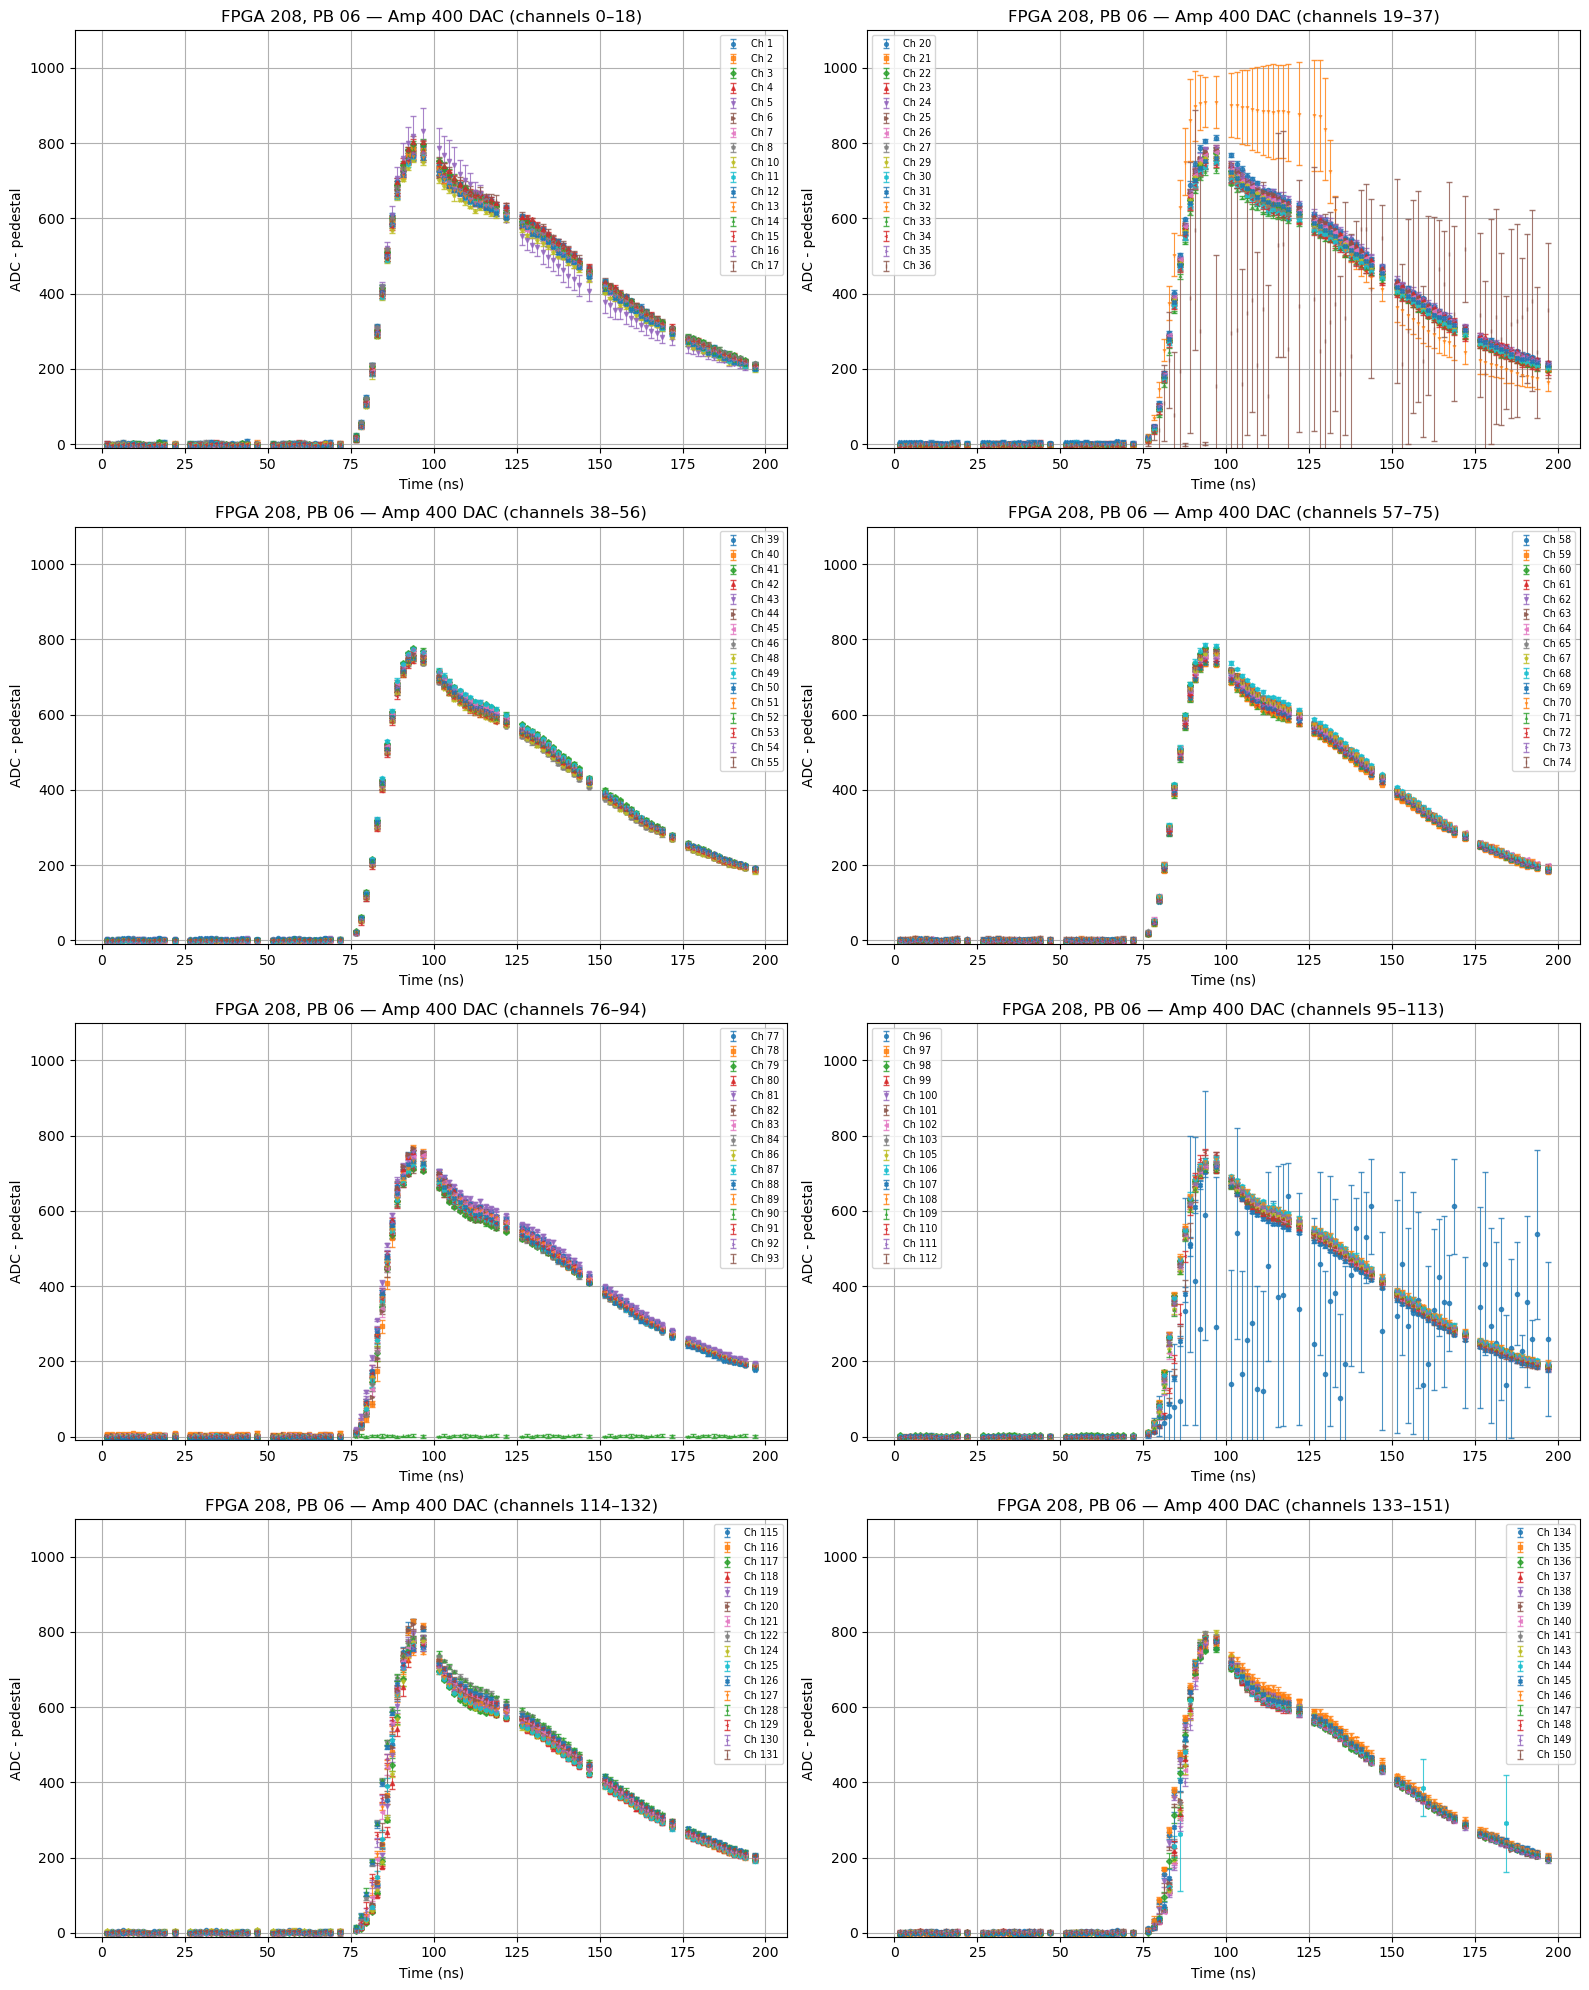

In [5]:
# ========= Extract the files for the specified amplitude and pair =========
try:
    run_files_mean = all_dirs[pair_key_mean][injected_amplitude_mean]   # dict: run_idx -> file_path
except KeyError:
    print(f"No files found for pair {pair_key_mean} and amplitude {injected_amplitude_mean}")
    raise

# ========= Figure =========
fig_mean, axs_mean = plt.subplots(4, 2, figsize=(16, 20))
axs_mean = axs_mean.flatten()

# ========= Loop over channel groups =========
for group_id in range(num_groups):
    ax = axs_mean[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group
    marker_index = 0

    for channel in range(first_channel, last_channel):
        # Skip unwanted channels
        if (channel in dead_channels or
            channel in calibration_channels or
            channel in notConnected_channels):
            continue

        # Get pedestal for this channel
        ped_i = pedestal_map_mean.get(channel, fallback_pedestal)

        # Collect data across all runs
        all_runs_data_mean = []

        for run_idx, file_path in run_files_mean.items():
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            df = pd.read_csv(file_path)
            df.columns = df.columns.str.strip()

            # Filter by channel and remove unwanted phases
            channel_data = df[
                (df['Channel'] == channel) &
                (~df['Phase'].isin([4, 6, 7]))
            ]

            if channel_data.empty:
                continue

            # Work on a copy to avoid SettingWithCopy warnings
            channel_data = channel_data.copy()

            # Subtract per-channel pedestal
            channel_data['ADC'] = channel_data['ADC'] - ped_i

            all_runs_data_mean.append(channel_data[['Time', 'ADC']])

        # If we collected data from any run for this channel
        if all_runs_data_mean:
            combined_data = pd.concat(all_runs_data_mean)

            # Compute mean and std per Time bin
            stats = (
                combined_data
                .groupby('Time')['ADC']
                .agg(['mean', 'std'])
                .reset_index()
            )

            # Plot mean with error bars (std)
            ax.errorbar(
                stats['Time'],
                stats['mean'],
                yerr=stats['std'],
                fmt=markers[marker_index % len(markers)],
                markersize=3,
                capsize=2,
                elinewidth=0.8,
                label=f'Ch {channel}',
                alpha=0.8,
            )
            marker_index += 1

    ax.set_title(
        f'FPGA {fpga_adc_mean}, PB {pb_adc_mean} — Amp {injected_amplitude_mean} DAC '
        f'(channels {first_channel}–{last_channel - 1})'
    )
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('ADC - pedestal')
    ax.set_ylim(-10, 1100)
    ax.grid(True)
    ax.legend(fontsize='x-small', markerscale=0.9)

plt.tight_layout()
plt.show()

# Optional save:
output_dir_mean = f'/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_adc_mean}_pb{pb_adc_mean}'
os.makedirs(output_dir_mean, exist_ok=True)
fig_mean.savefig(os.path.join(output_dir_mean, f'MeanChannelsWithError_fpga{fpga_adc_mean}-pb{pb_adc_mean}_{injected_amplitude_mean}DAC.png'))

# Config for ToT

In [6]:
##########################
## For ToT FPGA per run ##
##########################

# ========= Choices for ToT =========
pair_id_tot = 0                # 0 → (208,06), 1 → (209,008)
injected_amplitude_tot = 400   # must be in CONFIG_TOT["amplitudes"]
run_number_tot = 2             # 1–5

# ========= Extract FPGA–PB pair from CONFIG_TOT =========
fpga_tot, pb_tot = CONFIG_TOT["fpga_pb_pairs"][pair_id_tot]

pair_key_tot = f"fpga{fpga_tot}_pb{pb_tot}"
run_idx_tot = run_number_tot - 1   # convert to index (0–4)


############################
## For mean ToT FPGA plot ##
############################

# ========= User choices (ToT) =========
pair_id_tot_mean = 0              # 0 → (208,06), 1 → (209,008)
injected_amplitude_tot_mean = 400  # must exist in CONFIG_TOT["amplitudes"]

# ========= Get FPGA–PB pair from CONFIG_TOT =========
fpga_tot_mean, pb_tot_mean = CONFIG_TOT["fpga_pb_pairs"][pair_id_tot_mean]
pair_key_tot_mean = f"fpga{fpga_tot_mean}_pb{pb_tot_mean}"

## Plot ToT - 12b all channels per run

Using ToT file:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/400dac/inj_adc_samples_208_pb06_76_400_2.csv


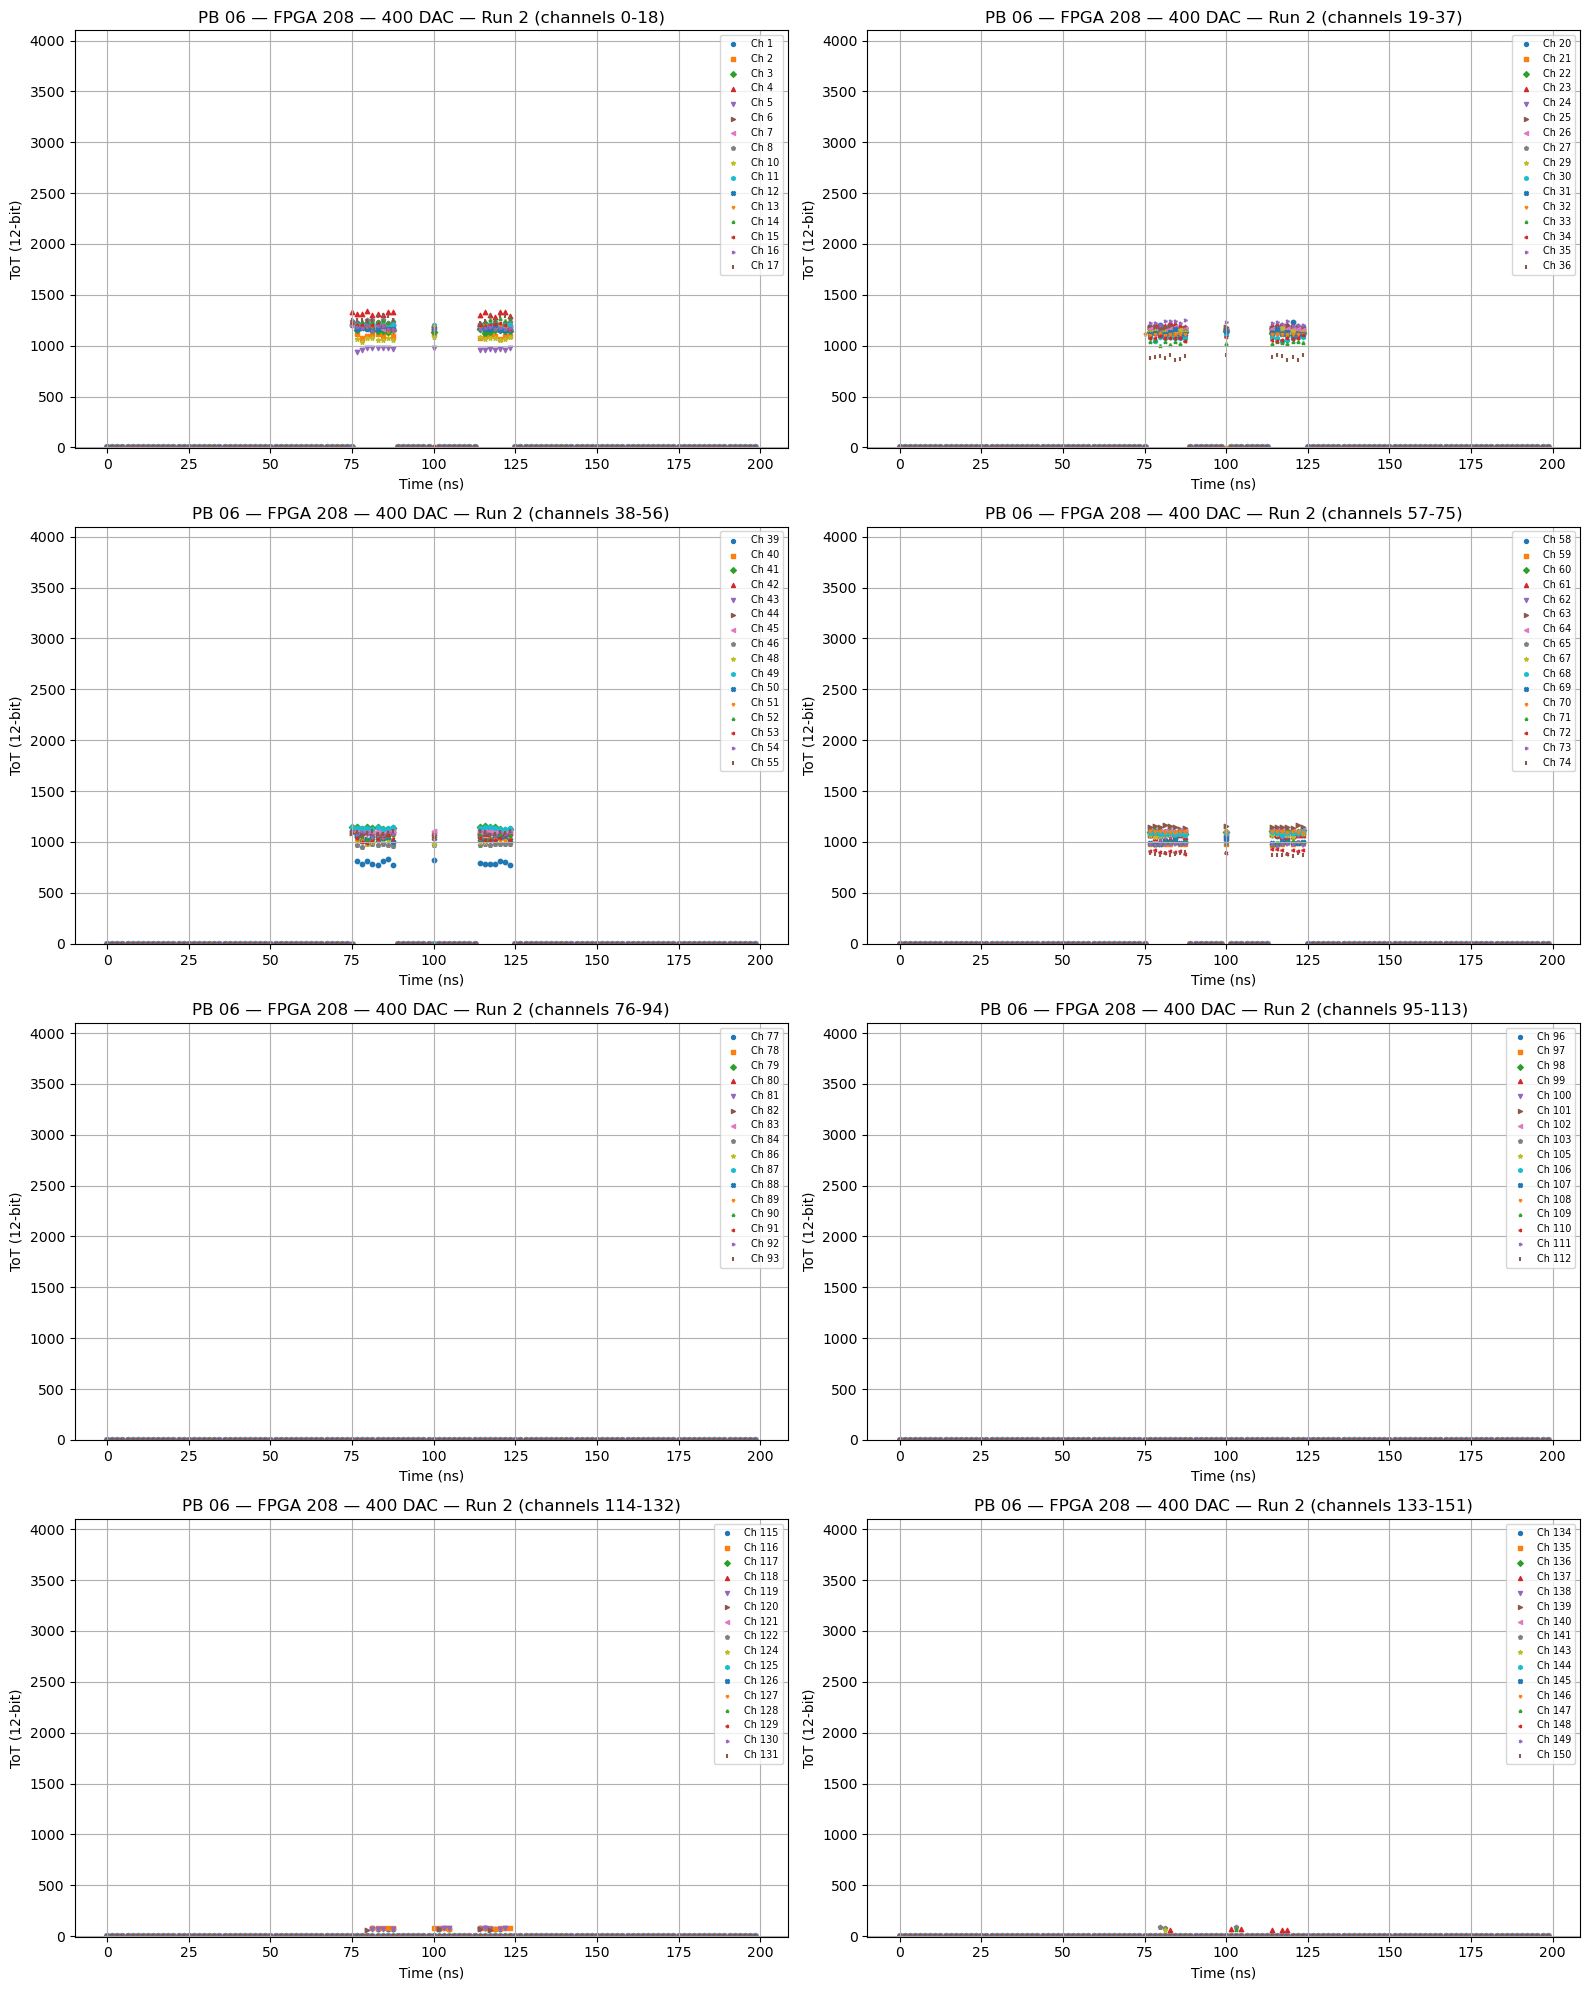

ToT figure saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_208_pb06/phases_ToT_fpga208-pb06_amp400_run2.png


In [7]:
# ========= Retrieve ToT file =========
try:
    data_file_tot = all_dirs_tot[pair_key_tot][injected_amplitude_tot][run_idx_tot]
except KeyError:
    print(f"No entry in all_dirs_tot for {pair_key_tot}, amplitude {injected_amplitude_tot}, run {run_number_tot}")
    raise

if not os.path.exists(data_file_tot):
    print(f"ToT file not found:\n{data_file_tot}")
    raise SystemExit

print(f"Using ToT file:\n  {data_file_tot}")

# ========= Read CSV =========
df_tot = pd.read_csv(data_file_tot)
df_tot.columns = df_tot.columns.str.strip()

# ========= Plotting ToT for all channels =========
fig_tot, axs = plt.subplots(4, 2, figsize=(16, 20))
axs = axs.flatten()

for group_id in range(num_groups):
    ax = axs[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group
    marker_index = 0

    for ch in range(first_channel, last_channel):
        # Skip unwanted channels
        if (ch in dead_channels or
            ch in calibration_channels or
            ch in notConnected_channels):
            continue

        channel_data = df_tot[df_tot["Channel"] == ch]
        if channel_data.empty:
            continue

        # Scatter ToT vs Time (use TOT_12bit; change to TOT_10bit if you want)
        ax.scatter(
            channel_data["Time"],
            channel_data["TOT_12bit"],
            label=f"Ch {ch}",
            marker=markers[marker_index % len(markers)],
            s=10
        )
        marker_index += 1

    ax.set_title(
        f"PB {pb_tot} — FPGA {fpga_tot} — {injected_amplitude_tot} DAC — Run {run_number_tot} "
        f"(channels {first_channel}-{last_channel-1})"
    )
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("ToT (12-bit)")
    ax.set_ylim(-5, 4100)   # full 12-bit range; adjust if you want
    ax.grid(True)
    ax.legend(fontsize="x-small", markerscale=0.9)

plt.tight_layout()
plt.show()

# ========= Save ToT figure =========
output_dir_tot = f"/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_tot}_pb{pb_tot}"
os.makedirs(output_dir_tot, exist_ok=True)

output_path_tot = os.path.join(
    output_dir_tot,
    f"phases_ToT_fpga{fpga_tot}-pb{pb_tot}_amp{injected_amplitude_tot}_run{run_number_tot}.png"
)

fig_tot.savefig(output_path_tot, dpi=200)
print(f"ToT figure saved to:\n  {output_path_tot}")


## Plot the ToT - 12b all channels (mean value of runs)

Found 5 ToT files for FPGA 208, PB 06


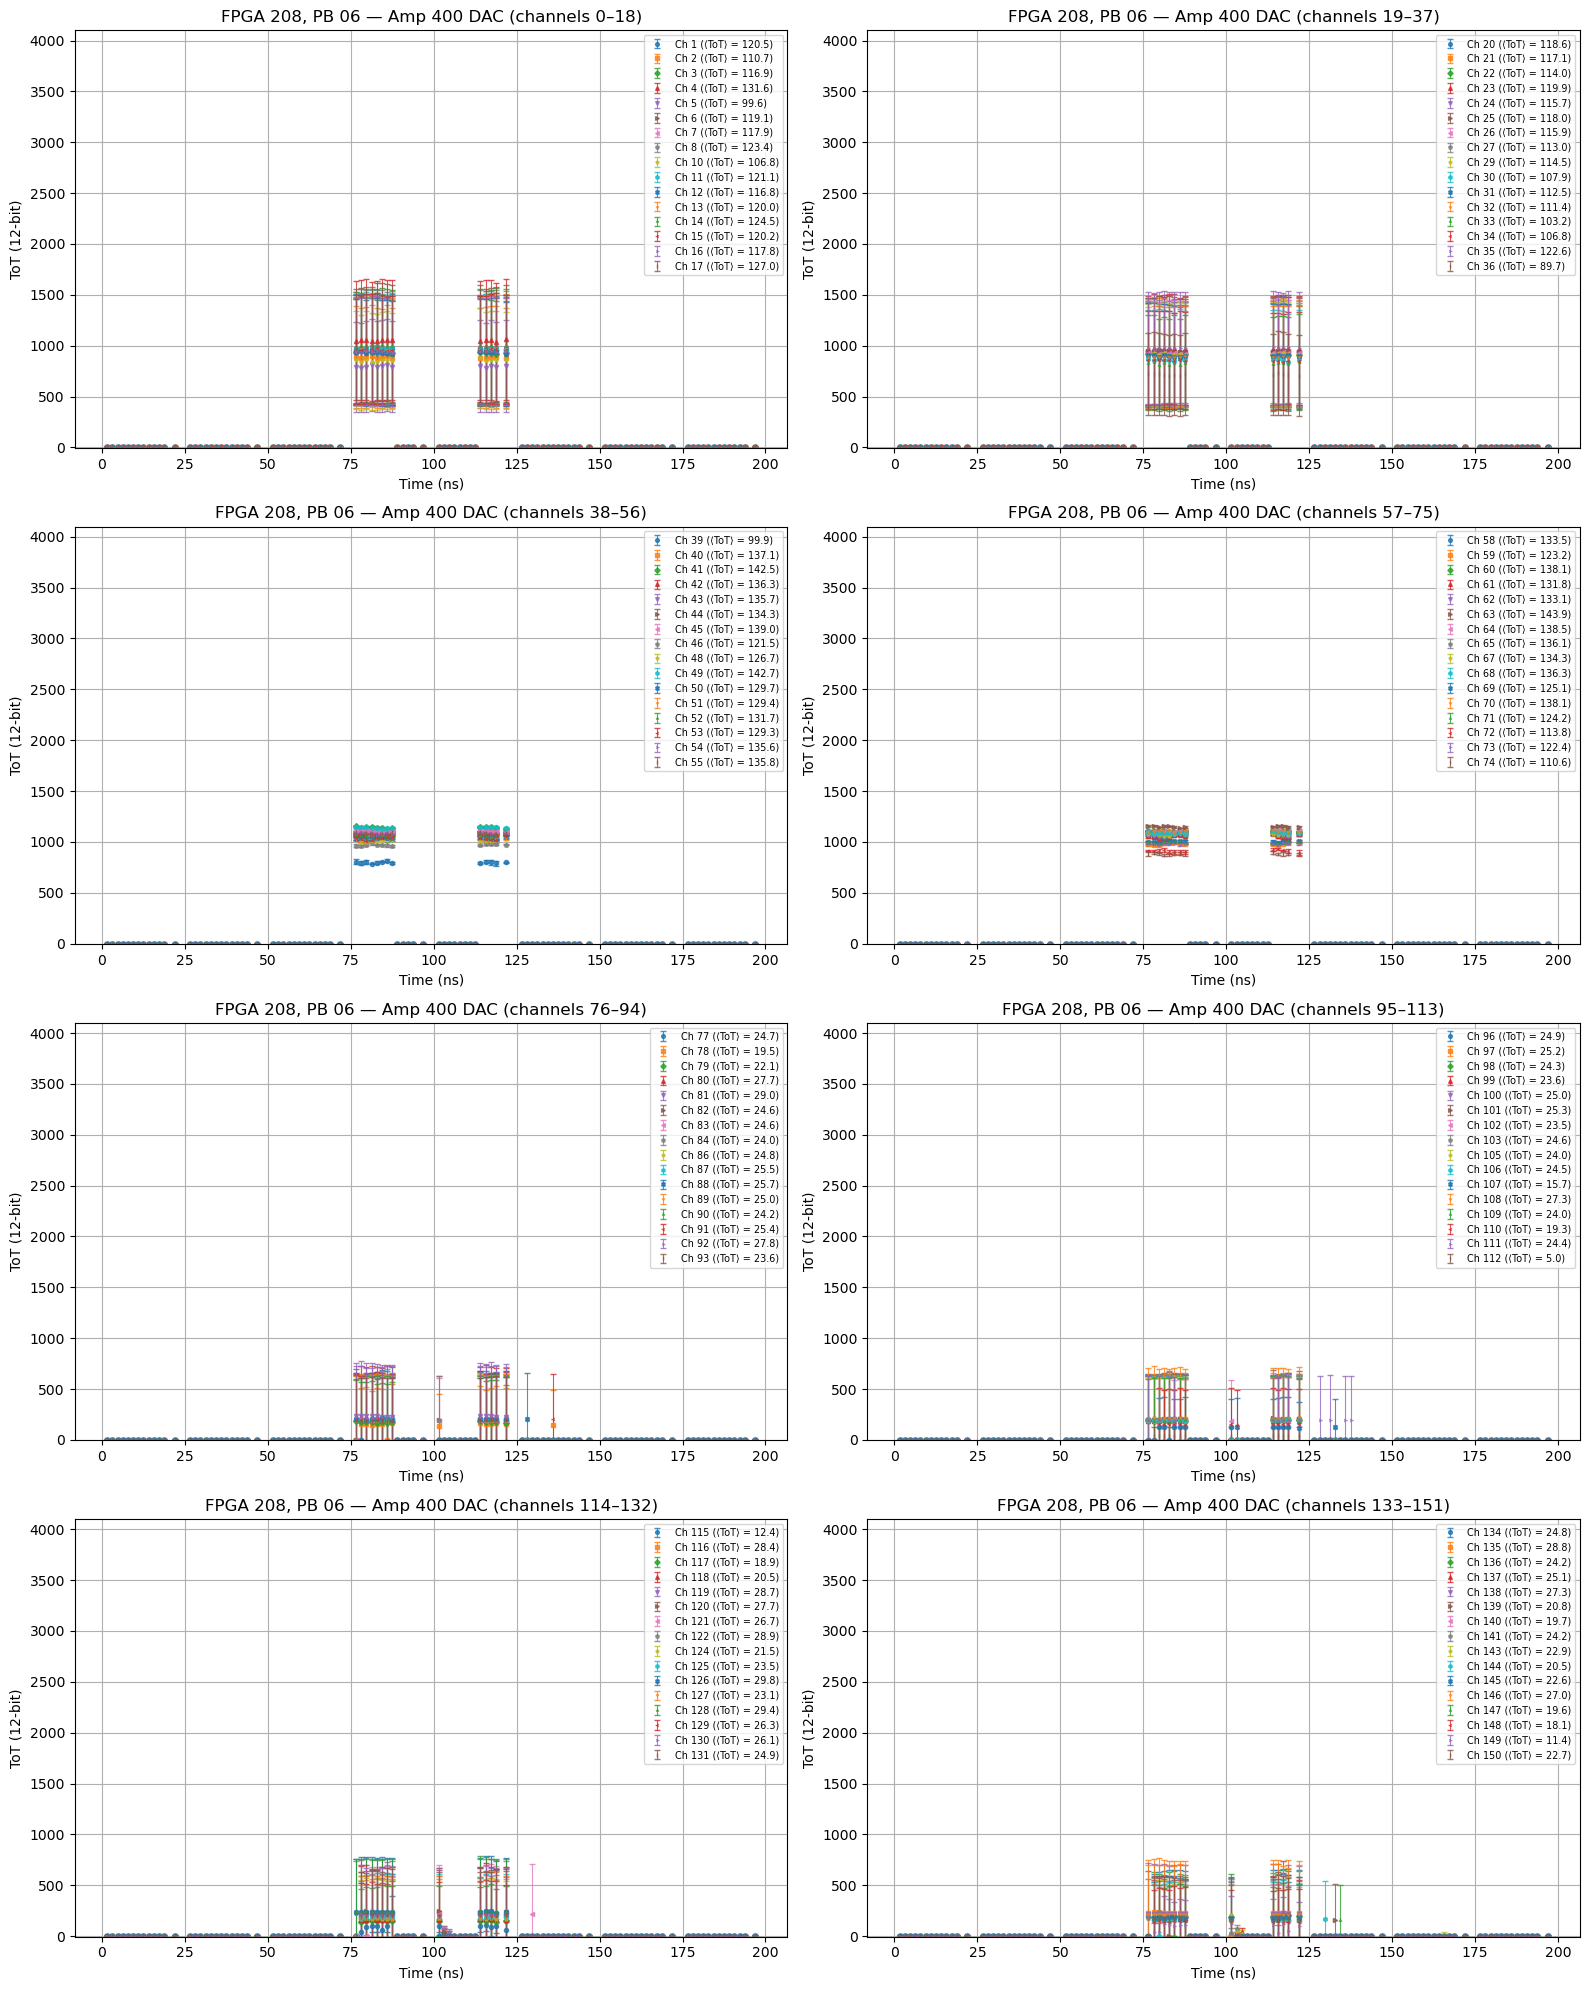

Saved ToT mean figure to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_208_pb06/Mean_ToT_fpga208-pb06_400DAC.png


In [8]:
# ========= Extract all run files for this ToT amplitude =========
try:
    run_files_tot_mean = all_dirs_tot[pair_key_tot_mean][injected_amplitude_tot_mean]
except KeyError:
    print(f"No ToT files found for pair {pair_key_tot_mean}, amplitude {injected_amplitude_tot_mean}")
    raise

print(f"Found {len(run_files_tot_mean)} ToT files for FPGA {fpga_tot_mean}, PB {pb_tot_mean}")

# ========= Figure for ToT mean plots =========
fig_tot_mean, axs_tot_mean = plt.subplots(4, 2, figsize=(16, 20))
axs_tot_mean = axs_tot_mean.flatten()

# ========= Loop over channel groups =========
for group_id in range(num_groups):
    ax = axs_tot_mean[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group
    marker_index = 0

    for channel in range(first_channel, last_channel):

        # Skip unwanted channels
        if (channel in dead_channels or
            channel in calibration_channels or
            channel in notConnected_channels):
            continue

        # Collect ToT data across runs
        all_runs_tot_mean = []

        for run_idx, file_path in run_files_tot_mean.items():
            if not os.path.exists(file_path):
                print(f"ToT file not found: {file_path}")
                continue

            df = pd.read_csv(file_path)
            df.columns = df.columns.str.strip()

            # Filter channel + remove unwanted phases
            ch_data = df[
                (df["Channel"] == channel) &
                (~df["Phase"].isin([4, 6, 7]))
            ]

            if ch_data.empty:
                continue

            # No pedestal subtraction for ToT
            all_runs_tot_mean.append(ch_data[["Time", "TOT_12bit"]])

        # If we collected any data for this channel:
        if all_runs_tot_mean:
            combined_tot = pd.concat(all_runs_tot_mean)

            # Compute mean and std per time bin
            stats_tot_mean = (
                combined_tot
                .groupby("Time")["TOT_12bit"]
                .agg(["mean", "std"])
                .reset_index()
            )

            # ===== NEW: compute global mean of this channel's mean curve =====
            mean_tot_overall = stats_tot_mean["mean"].mean()
            
            # Plot mean ToT ± error bars
            ax.errorbar(
                stats_tot_mean["Time"],
                stats_tot_mean["mean"],
                yerr=stats_tot_mean["std"],
                fmt=markers[marker_index % len(markers)],
                markersize=3,
                capsize=2,
                elinewidth=0.8,
                # label with global mean added
                label=f"Ch {channel} (⟨ToT⟩ = {mean_tot_overall:.1f})",
                alpha=0.8,
            )
            marker_index += 1

    ax.set_title(
        f"FPGA {fpga_tot_mean}, PB {pb_tot_mean} — Amp {injected_amplitude_tot_mean} DAC "
        f"(channels {first_channel}–{last_channel - 1})"
    )
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("ToT (12-bit)")
    ax.set_ylim(-5, 4100)
    ax.grid(True)
    ax.legend(fontsize="x-small", markerscale=0.9)

plt.tight_layout()
plt.show()

# ========= Save ToT figure =========
output_dir_tot_mean = (
    f"/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/"
    f"FPGA_{fpga_tot_mean}_pb{pb_tot_mean}"
)
os.makedirs(output_dir_tot_mean, exist_ok=True)

output_path_tot_mean = os.path.join(
    output_dir_tot_mean,
    f"Mean_ToT_fpga{fpga_tot_mean}-pb{pb_tot_mean}_{injected_amplitude_tot_mean}DAC.png"
)

fig_tot_mean.savefig(output_path_tot_mean, dpi=200)
print(f"Saved ToT mean figure to:\n  {output_path_tot_mean}")


## Extract ADC peak per amplitude ADC Just for one run

In [9]:
def extract_peaks(all_dirs_pair, channel, pedestal_value):
    """
    Extract peak ADC values per amplitude and per run for one channel.

    Parameters:
        all_dirs_pair : dict
            Dictionary for one FPGA-PB pair:
            { amplitude : { run_idx : file_path } }
        channel : int
            Channel number to extract peaks from.
        pedestal_value : float or int
            Pedestal to subtract from ADC values.

    Returns:
        amplitudes_list : list
            One entry per run (e.g. [100,100,100,200,200,200,...])
        peaks_list : list
            Peak ADC values per run after pedestal subtraction.
    """

    amplitudes_list = []
    peaks_list = []

    for amplitude, runs_dict in all_dirs_pair.items():
        for run_idx, run_file in runs_dict.items():

            if not os.path.exists(run_file):
                print(f"File not found: {run_file}")
                continue

            df = pd.read_csv(run_file)
            df.columns = df.columns.str.strip()

            # Check required columns
            if not set(["Channel", "ADC", "Phase"]).issubset(df.columns):
                print(f"Missing required columns in file {run_file}")
                continue

            # Filter channel & remove unwanted phases
            channel_data = df[
                (df["Channel"] == channel) &
                (~df["Phase"].isin([4, 6, 7]))
            ]

            if channel_data.empty:
                # No data for this channel in this run
                continue

            # Extract peak minus pedestal
            peak_val = channel_data["ADC"].max() - pedestal_value

            amplitudes_list.append(amplitude)
            peaks_list.append(peak_val)

    return amplitudes_list, peaks_list


## Extract adc peak per amplitude, per run, minus pedestal

In [10]:
def get_adc_max_per_channel(
    all_dirs_pair,
    pedestal_map,
    amplitudes=None,
    fallback_pedestal=80,
    exclude_phases=(4, 6, 7),
):
    """
    Compute the maximum ADC per channel and per run (pedestal-subtracted)
    for a given FPGA–PB pair.

    Parameters
    ----------
    all_dirs_pair : dict
        Dictionary for one FPGA-PB pair:
        { amplitude : { run_idx : file_path } }
        e.g. all_dirs["fpga208_pb06"]

    pedestal_map : dict
        Channel → pedestal value, e.g. {0: 81.2, 1: 79.8, ...}

    amplitudes : list or None
        List of amplitudes (DAC values) to use.
        If None, use all amplitudes present in all_dirs_pair.

    fallback_pedestal : float
        Value to use if a channel is not found in pedestal_map.

    exclude_phases : iterable
        Phases to exclude (as in your other code, typically [4, 6, 7]).

    Returns
    -------
    df_max : pandas.DataFrame
        Columns:
            - "Amplitude"  (DAC)
            - "Run"        (run index, 0–4)
            - "Channel"
            - "ADC_max_raw"
            - "Pedestal"
            - "ADC_max_minus_ped"
    """

    rows = []

    # Decide which amplitudes to loop over
    if amplitudes is None:
        amplitudes_to_use = sorted(all_dirs_pair.keys())
    else:
        amplitudes_to_use = amplitudes

    for amplitude in amplitudes_to_use:
        runs_dict = all_dirs_pair.get(amplitude, {})
        if not runs_dict:
            print(f"[WARNING] No runs found for amplitude {amplitude}")
            continue

        for run_idx, run_file in runs_dict.items():
            if not os.path.exists(run_file):
                print(f"[WARNING] File not found: {run_file}")
                continue

            df = pd.read_csv(run_file)
            df.columns = df.columns.str.strip()

            # Check required columns
            required_cols = {"Channel", "ADC", "Phase"}
            if not required_cols.issubset(df.columns):
                print(f"[WARNING] Missing required columns in {run_file}")
                continue

            # Remove unwanted phases
            df_use = df[~df["Phase"].isin(exclude_phases)].copy()
            if df_use.empty:
                continue

            # Group by channel and get max ADC
            grouped = df_use.groupby("Channel")["ADC"].max().reset_index()
            grouped = grouped.rename(columns={"ADC": "ADC_max_raw"})

            # Attach pedestal and pedestal-subtracted max
            for _, row in grouped.iterrows():
                ch = int(row["Channel"])
                adc_max_raw = float(row["ADC_max_raw"])
                ped = pedestal_map.get(ch, fallback_pedestal)
                adc_corr = adc_max_raw - ped

                rows.append({
                    "Amplitude": amplitude,
                    "Run": run_idx,
                    "Channel": ch,
                    "ADC_max_raw": adc_max_raw,
                    "Pedestal": ped,
                    "ADC_max_minus_ped": adc_corr,
                })

    df_max = pd.DataFrame(rows)
    return df_max


### Get Mean Peak vs Amplitude per Channel and Save it

In [11]:
all_dirs_pair = all_dirs[pair_key_mean]         # dict: amp -> runs
amplitudes_cfg = CONFIG["amplitudes"]           # [100, 200, 300, 400]

df_max_adc = get_adc_max_per_channel(
    all_dirs_pair=all_dirs_pair,
    pedestal_map=pedestal_map_mean,
    amplitudes=amplitudes_cfg,
    fallback_pedestal=fallback_pedestal
)

print(df_max_adc.head())


peaks_summary = (
    df_max_adc
    .groupby(["Channel", "Amplitude"])["ADC_max_minus_ped"]
    .agg(["mean", "std"])
    .reset_index()
)

print(peaks_summary.tail())

   Amplitude  Run  Channel  ADC_max_raw  Pedestal  ADC_max_minus_ped
0        100    0        1        252.0      93.0              159.0
1        100    0        2        234.0      83.0              151.0
2        100    0        3        234.0      81.0              153.0
3        100    0        4        246.0      88.0              158.0
4        100    0        5        231.0      82.0              149.0
     Channel  Amplitude   mean       std
571      149        400  774.2  4.919350
572      150        100  162.0  2.236068
573      150        200  338.8  3.193744
574      150        300  534.6  5.128353
575      150        400  769.4  4.335897


In [12]:
output_dir_peaks = (
    "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/ADC_Peaks"
)
# === Create folder if it does not exist ===
os.makedirs(output_dir_peaks, exist_ok=True)

output_csv_peaks_path = os.path.join(
    output_dir_peaks,
    f"adc_peaks_summary_fpga{fpga_adc_mean}_pb{pb_adc_mean}.csv"
)

# === Save the DataFrame ===
peaks_summary.to_csv(output_csv_peaks_path, index=False)

print(f"CSV saved to:\n  {output_csv_peaks_path}")

CSV saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/ADC_Peaks/adc_peaks_summary_fpga208_pb06.csv


### Find Best Phase in ToT

## Linearity in ADC All Channels

In [13]:
# -------- Linearity config --------
acceptance_value = 0.98  # R² threshold
good_linearity_channels = []
bad_linearity_channels = []
channel_r2_dict = {}
channel_linperc_dict = {}

pb_key = pb_adc_mean  # e.g. "06" or "008"

# === Manually discarded channels (unstable, noisy, unwanted, etc.) ===
# Manually discarded channels per FPGA–PB pair
# Keys are (fpga, pb) as strings, same as in CONFIG["fpga_pb_pairs"]
manual_discarded_by_pair = {
    ("208", "06"): {21, 36, 90, 96},
    ("209", "008"): {},
}

Manual discarded channels for this pair: {96, 90, 36, 21}


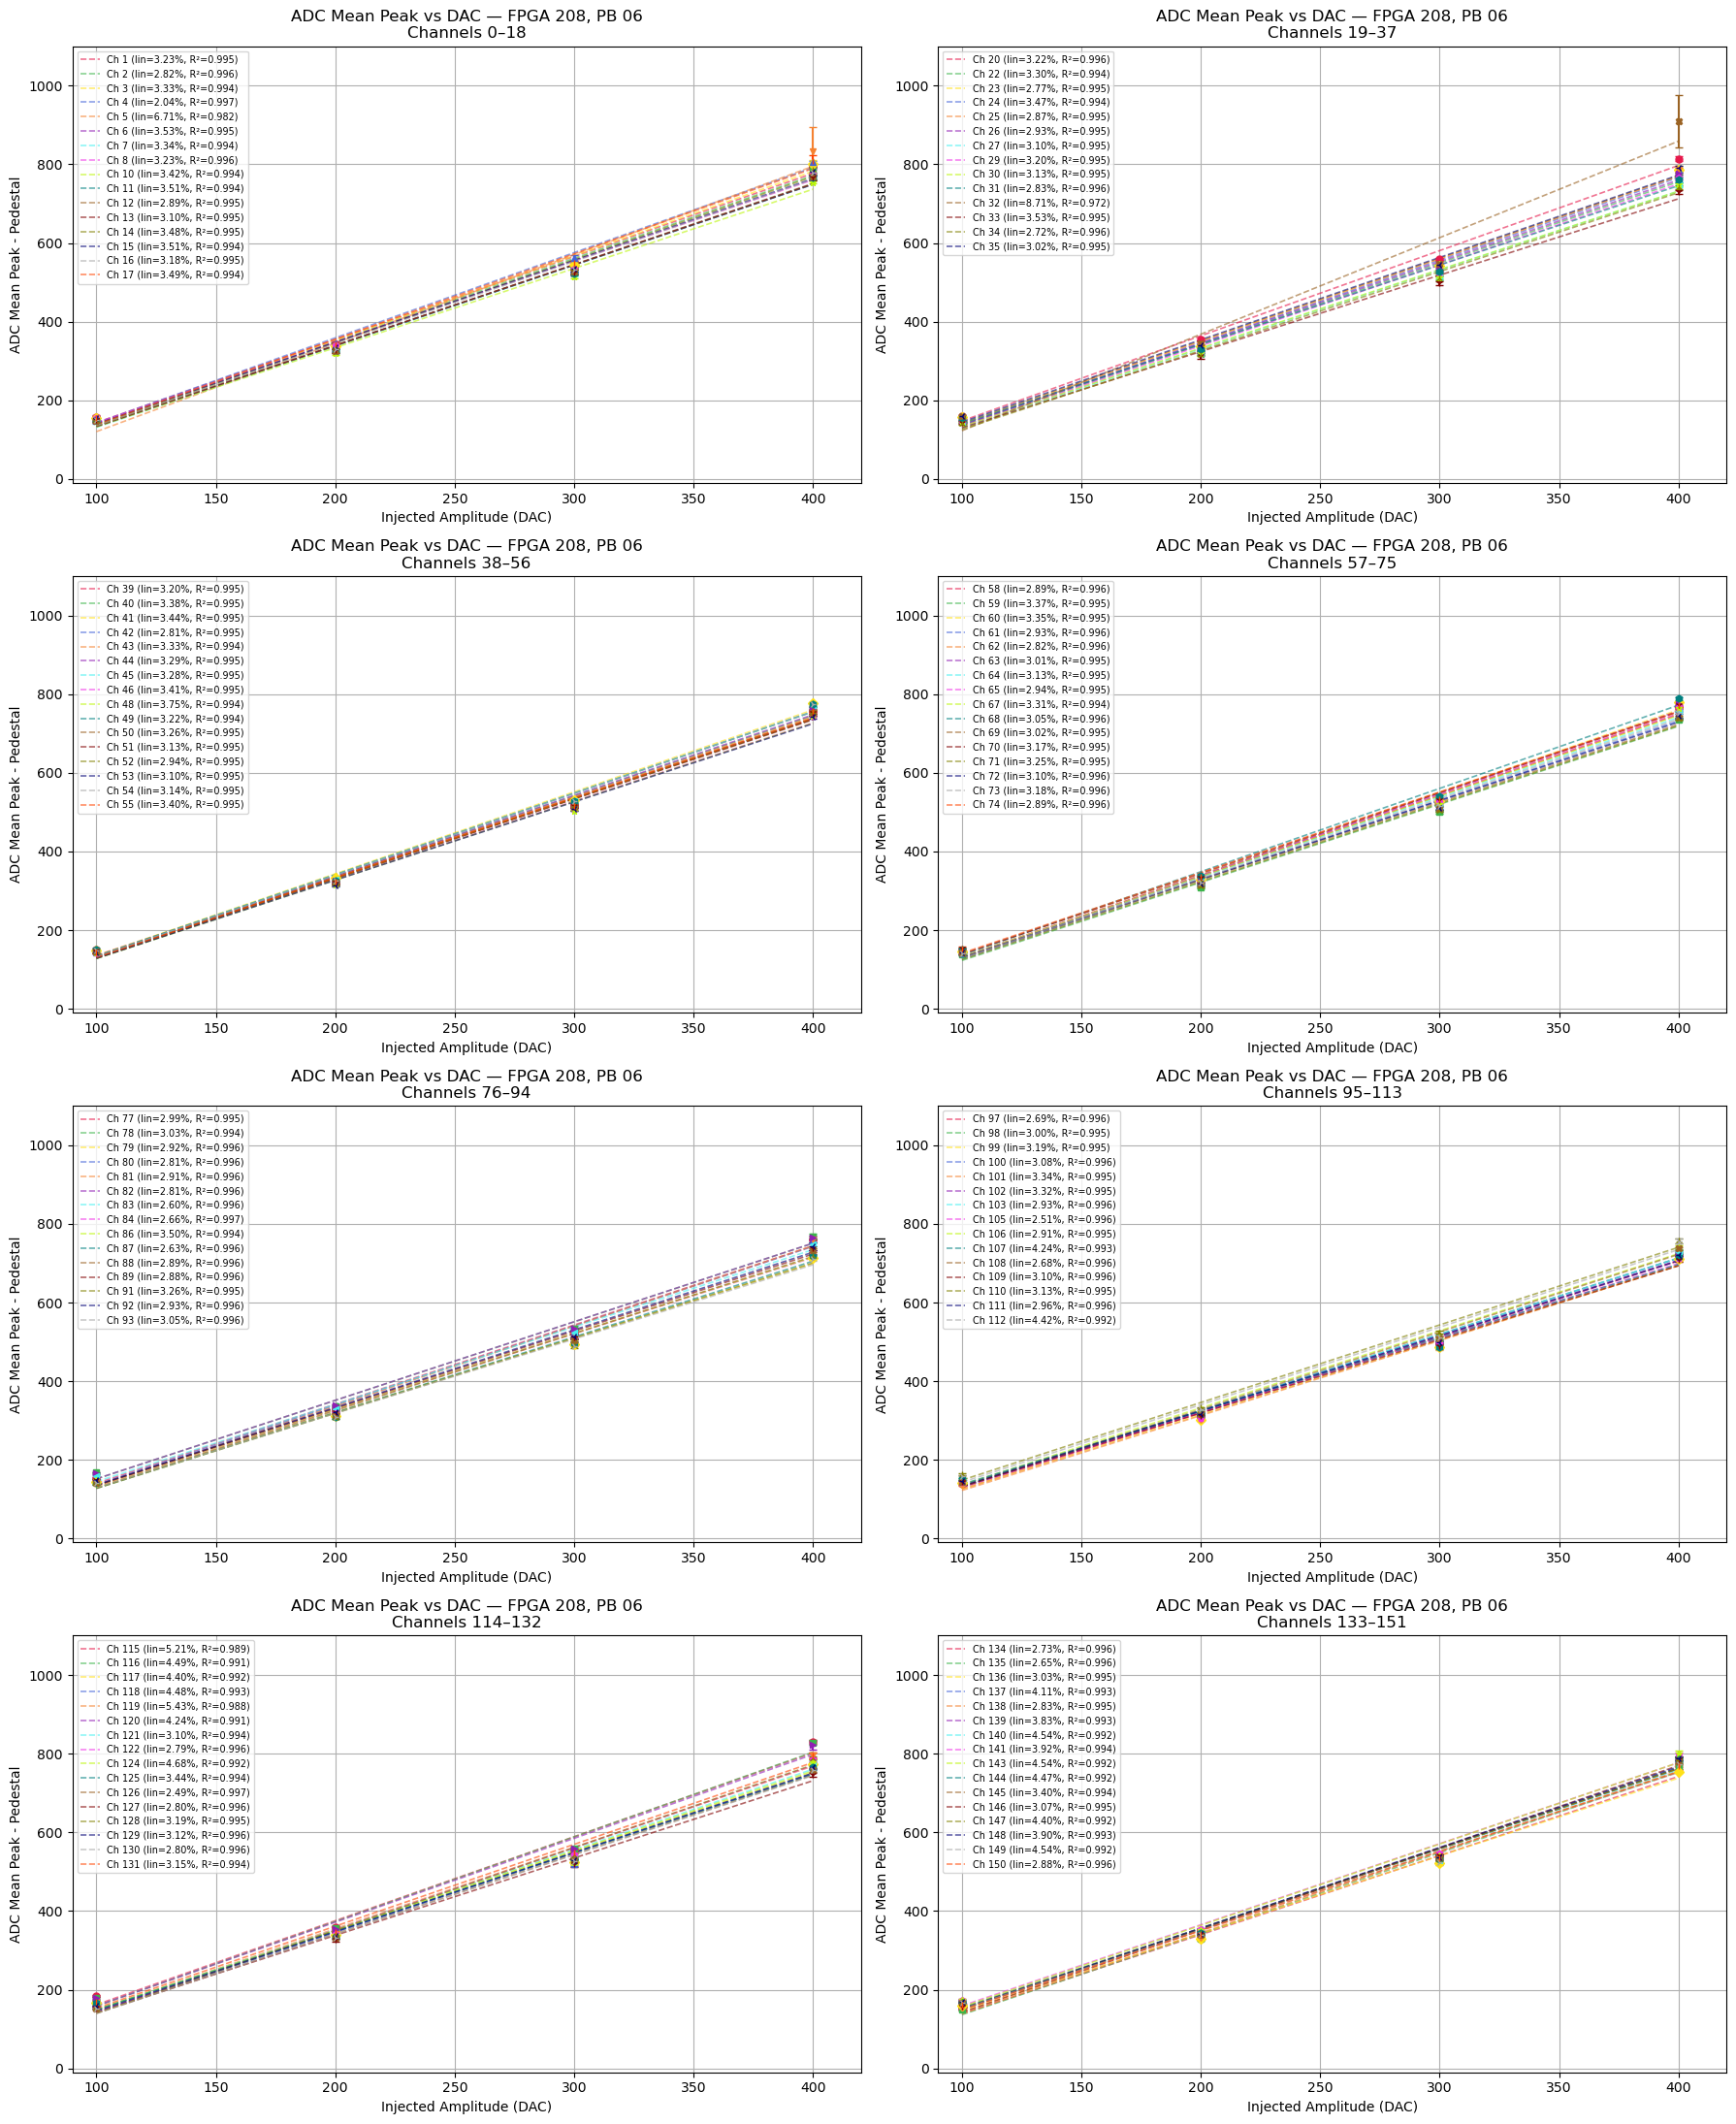


🟢 Good Linearity Channels (123 channels):
1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150

🔴 Bad Linearity Channels (1 channels):
32

Percentage of Good Linearity Channels: 99.19%

Channel R² and linearity%:
Channel 1: R² = 0.995, linearity = 3.23%
Channel 2: R² = 0.996, linearity = 2.82%
Channel 3: R² = 0.994, linearity = 3.33%
Channel 4: R² = 0.997, linearity = 2.04%
Channel 5: R² = 0.982, linearity = 6.71%
Channel 6: R² = 0.995, linearity = 3.53%
Channel 7: R² = 0.994, linearity = 3.34%
Channel 8: R² = 0.996, li

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(18, 22))
axs = axs.flatten()

# Pick the right manual-discard list for this FPGA–PB pair
manual_discarded_channels = manual_discarded_by_pair.get(
    (fpga_adc_mean, pb_adc_mean),
    set()  # default: no manual discards if pair not in dict
)
print("Manual discarded channels for this pair:", manual_discarded_channels)

for group_id in range(num_groups):
    ax = axs[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group

    marker_index = 0  # will index both color_list and markers

    for ch in range(first_channel, last_channel):

        # Skip unwanted channels
        if (ch in dead_channels or
            ch in calibration_channels or
            ch in notConnected_channels or
            ch in manual_discarded_channels):
            continue

        # Select this channel's summary (mean & std over runs)
        df_ch = peaks_summary[peaks_summary["Channel"] == ch]
        if df_ch.empty:
            continue

        # Sort by amplitude
        df_ch = df_ch.sort_values("Amplitude")
        amps  = df_ch["Amplitude"].values
        means = df_ch["mean"].values
        stds  = df_ch["std"].values

        if len(amps) < 2:
            # not enough points to fit a line
            continue

        # Pick color & marker for THIS channel
        color  = color_list[marker_index % len(color_list)]
        marker = markers[marker_index % len(markers)]

        # --- Scatter + error bars: one per channel ---
        ax.errorbar(
            amps, means,
            yerr=stds,
            fmt=marker,
            markersize=5,
            capsize=3,
            color=color,
            ecolor=color,
            linestyle="none",  # no connecting line here
        )

        # --- Linear regression for THIS channel ---
        slope, intercept, r_value, p_value, std_err = linregress(amps, means)
        r2 = r_value ** 2
        
        # --- Deviation-based linearity  ---
        fit_vals = slope * amps + intercept
        deviations = means - fit_vals
        max_deviation = np.max(np.abs(deviations))
        full_scale = np.max(means) - np.min(means)
        
        if full_scale > 0:
            linearity_percentage = max_deviation / full_scale * 100
        else:
            linearity_percentage = 0.0
            
        # Store in dicts
        channel_r2_dict[ch] = r2
        channel_linperc_dict[ch] = linearity_percentage
        
        # --- Classify good / bad linearity ---
        if r2 >= acceptance_value:
            good_linearity_channels.append(ch)
        else:
            bad_linearity_channels.append(ch)

        x_line = np.linspace(amps.min(), amps.max(), 200)
        y_line = slope * x_line + intercept

        # Regression line: same color, dashed, slightly transparent
        ax.plot(
            x_line, y_line,
            linestyle="--",
            linewidth=1.2,
            alpha=0.6,
            color=color,
            label=f"Ch {ch} (lin={linearity_percentage:.2f}%, R²={r2:.3f})"
        )

        marker_index += 1

    ax.set_title(
        f"ADC Mean Peak vs DAC — FPGA {fpga_adc_mean}, PB {pb_adc_mean}\n"
        f"Channels {first_channel}–{last_channel - 1}"
    )
    ax.set_xlabel("Injected Amplitude (DAC)")
    ax.set_ylabel("ADC Mean Peak - Pedestal")
    ax.set_ylim(-10, 1100)
    ax.set_xlim(min(CONFIG['amplitudes']) - 10,
                max(CONFIG['amplitudes']) + 20)
    ax.grid(True)
    ax.legend(fontsize="x-small", markerscale=1)

plt.tight_layout()
plt.show()

# -------- Summary printouts --------
def print_channel_list(label, channels):
    chs = sorted(set(channels))
    print(f"\n{label} ({len(chs)} channels):")
    print(", ".join(str(int(c)) for c in chs))

print_channel_list("🟢 Good Linearity Channels", good_linearity_channels)
print_channel_list("🔴 Bad Linearity Channels", bad_linearity_channels)

# Percentage (using actually evaluated channels)
all_evaluated = set(good_linearity_channels) | set(bad_linearity_channels)
total_channels_eval = len(all_evaluated)
percentage_good = (
    len(set(good_linearity_channels)) / total_channels_eval * 100
    if total_channels_eval > 0 else 0
)
print(f"\nPercentage of Good Linearity Channels: {percentage_good:.2f}%")

print("\nChannel R² and linearity%:")
for channel in sorted(all_evaluated):
    r2 = channel_r2_dict.get(channel, float("nan"))
    linp = channel_linperc_dict.get(channel, float("nan"))
    print(f"Channel {channel}: R² = {r2:.3f}, linearity = {linp:.2f}%")

### Saving the linearity and $R^2$ Values

In [18]:
# --- Folder where ADC peaks are saved ---
output_csv_peaks_path = os.path.join(
    "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025",
    "ADC_Peaks"
)

# Create folder if missing
os.makedirs(output_csv_peaks_path, exist_ok=True)

# --- Build dataframe from channel → (r2, linearity%) ---
summary_data = []

for ch in sorted(channel_r2_dict.keys()):
    r2 = channel_r2_dict.get(ch, float("nan"))
    linp = channel_linperc_dict.get(ch, float("nan"))
    summary_data.append({
        "Channel": ch,
        "R2": r2,
        "Linearity_percent": linp,
        "GoodLinearity": ch in good_linearity_channels,
    })

summary_df = pd.DataFrame(summary_data)

# --- Build a filename ---
csv_filename = f"ADC_LinearitySummary_fpga{fpga_adc_mean}_pb{pb_adc_mean}.csv"

# --- Full path ---
csv_path = os.path.join(output_csv_peaks_path, csv_filename)

# --- Save CSV ---
summary_df.to_csv(csv_path, index=False)

print("\nSaved ADC linearity summary to:")
print(csv_path)


Saved ADC linearity summary to:
/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/ADC_Peaks/ADC_LinearitySummary_fpga208_pb06.csv


## Inspect ADC of one channel

In [22]:
##################################
## Setitng the channel to study ##
##################################

# ===== Choose the channel you want to inspect =====
channel_of_interest = 50   # <-- change this number as you like

Manual discarded channels for this pair: {96, 90, 36, 21}


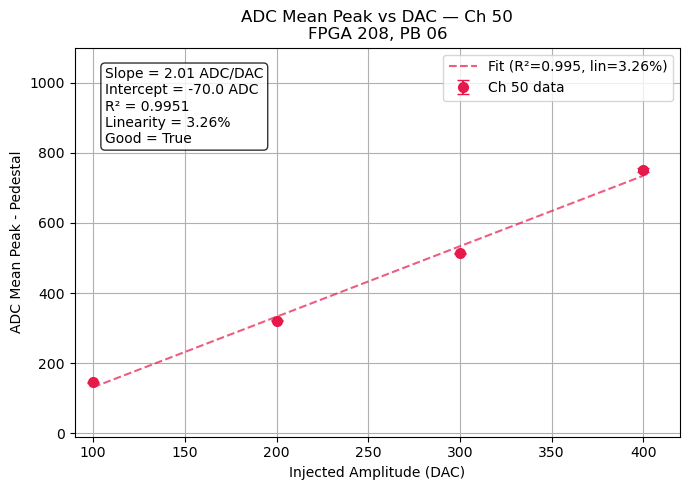

Figure saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_208_pb06/linearity_channel50_fpga208-pb06_amp400_allruns.png


In [25]:
# Get manual discarded channels for this FPGA–PB pair
manual_discarded_channels = manual_discarded_by_pair.get(
    (fpga_adc_mean, pb_adc_mean),
    set()
)
print("Manual discarded channels for this pair:", manual_discarded_channels)

# ===== Check if this channel is allowed =====
if (channel_of_interest in dead_channels or
    channel_of_interest in calibration_channels or
    channel_of_interest in notConnected_channels or
    channel_of_interest in manual_discarded_channels):
    print(f"Channel {channel_of_interest} is in a discarded list (dead/calibration/notConnected/manual).")
else:
    # Select this channel's summary (mean & std over runs)
    df_ch = peaks_summary[peaks_summary["Channel"] == channel_of_interest]

    if df_ch.empty:
        print(f"No data found in peaks_summary for channel {channel_of_interest}.")
    else:
        # Sort by amplitude
        df_ch = df_ch.sort_values("Amplitude")
        amps  = df_ch["Amplitude"].values
        means = df_ch["mean"].values
        stds  = df_ch["std"].values

        if len(amps) < 2:
            print(f"Not enough amplitude points to fit a line for channel {channel_of_interest}.")
        else:
            # Pick a color + marker (just the first ones, or change if you want)
            color  = color_list[0]
            marker = markers[0]

            # ----- Linear regression -----
            slope, intercept, r_value, p_value, std_err = linregress(amps, means)
            r2 = r_value ** 2

            # Deviation-based linearity (%)
            fit_vals = slope * amps + intercept
            deviations = means - fit_vals
            max_deviation = np.max(np.abs(deviations))
            full_scale = np.max(means) - np.min(means)

            if full_scale > 0:
                linearity_percentage = max_deviation / full_scale * 100
            else:
                linearity_percentage = 0.0

            # Classification (optional, just to know)
            is_good = r2 >= acceptance_value

            # ----- Plot -----
            fig, ax = plt.subplots(figsize=(7, 5))

            # Error bars (mean ± std)
            ax.errorbar(
                amps, means,
                yerr=stds,
                fmt=marker,
                markersize=7,
                capsize=4,
                color=color,
                ecolor=color,
                linestyle="none",
                label=f"Ch {channel_of_interest} data",
            )

            # Regression line
            x_line = np.linspace(amps.min(), amps.max(), 200)
            y_line = slope * x_line + intercept

            ax.plot(
                x_line, y_line,
                linestyle="--",
                linewidth=1.5,
                alpha=0.7,
                color=color,
                label=f"Fit (R²={r2:.3f}, lin={linearity_percentage:.2f}%)"
            )

            # Labels, title, etc.
            ax.set_title(
                f"ADC Mean Peak vs DAC — Ch {channel_of_interest}\n"
                f"FPGA {fpga_adc_mean}, PB {pb_adc_mean}"
            )
            ax.set_xlabel("Injected Amplitude (DAC)")
            ax.set_ylabel("ADC Mean Peak - Pedestal")
            ax.set_xlim(min(CONFIG["amplitudes"]) - 10,
                        max(CONFIG["amplitudes"]) + 20)
            ax.set_ylim(-10, 1100)
            ax.grid(True)
            ax.legend(loc="best")

            # Optional: small text box with info
            txt = (
                f"Slope = {slope:.2f} ADC/DAC\n"
                f"Intercept = {intercept:.1f} ADC\n"
                f"R² = {r2:.4f}\n"
                f"Linearity = {linearity_percentage:.2f}%\n"
                f"Good = {is_good}"
            )
            ax.text(
                0.05, 0.95, txt,
                transform=ax.transAxes,
                va="top", ha="left",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
            )

            plt.tight_layout()
            plt.show()

# ========= Save figure =========
output_dir = f'/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_adc}_pb{pb_adc}'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(
    output_dir,
    f'linearity_channel{channel_of_interest}_fpga{fpga_adc}-pb{pb_adc}_amp{injected_amplitude}_allruns.png'
)

fig.savefig(output_path, dpi=200)
print(f"Figure saved to:\n  {output_path}")


### Waweforms of Only One Channel

Channel of interest: 50
Manual discarded channels for this pair: {96, 90, 36, 21}
Using pedestal = 77.0 ADC for channel 50


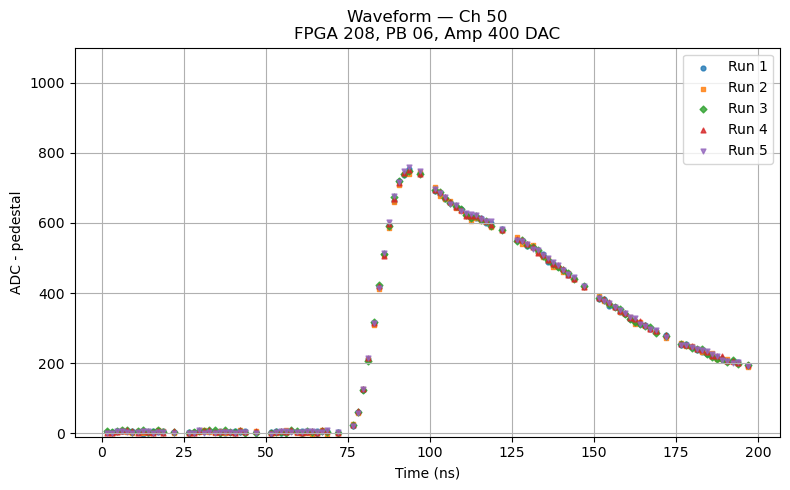

Figure saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_208_pb06/phases_channel50_fpga208-pb06_amp400_allruns.png


In [27]:
# ===== Waveform of ONE channel over ALL runs =====

print(f"Channel of interest: {channel_of_interest}")

# Check if the channel is allowed
manual_discarded_channels = manual_discarded_by_pair.get(
    (fpga_adc_mean, pb_adc_mean),
    set()
)
print("Manual discarded channels for this pair:", manual_discarded_channels)

if (channel_of_interest in dead_channels or
    channel_of_interest in calibration_channels or
    channel_of_interest in notConnected_channels or
    channel_of_interest in manual_discarded_channels):
    print(f"⚠️ Channel {channel_of_interest} is in a discarded list (dead/calibration/notConnected/manual).")
else:
    # Get all run files for this amplitude and pair
    try:
        run_files = all_dirs[pair_key_mean][injected_amplitude_mean]   # dict: run_idx -> file_path
    except KeyError:
        print(f"No files found for pair {pair_key_mean} and amplitude {injected_amplitude_mean}")
        run_files = {}

    if not run_files:
        print("No run files available for this configuration.")
    else:
        fig, ax = plt.subplots(figsize=(8, 5))

        ped_i = pedestal_map.get(channel_of_interest, fallback_pedestal)
        print(f"Using pedestal = {ped_i:.1f} ADC for channel {channel_of_interest}")

        any_data = False

        for run_idx, file_path in run_files.items():
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            df = pd.read_csv(file_path)
            df.columns = df.columns.str.strip()

            # Filter this channel, optionally remove weird phases
            ch_data = df[
                (df["Channel"] == channel_of_interest) &
                (~df["Phase"].isin([4, 6, 7]))
            ]

            if ch_data.empty:
                print(f"No data for channel {channel_of_interest} in run {run_idx+1}")
                continue

            any_data = True

            # Subtract pedestal
            adc_corr = ch_data["ADC"] - ped_i

            # Pick a marker per run
            marker = markers[run_idx % len(markers)]

            ax.scatter(
                ch_data["Time"],
                adc_corr,
                s=12,
                marker=marker,
                label=f"Run {run_idx+1}",
                alpha=0.8,
            )

        if not any_data:
            print(f"No valid data found for channel {channel_of_interest} in any run.")
        else:
            ax.set_title(
                f"Waveform — Ch {channel_of_interest}\n"
                f"FPGA {fpga_adc_mean}, PB {pb_adc_mean}, Amp {injected_amplitude_mean} DAC"
            )
            ax.set_xlabel("Time (ns)")
            ax.set_ylabel("ADC - pedestal")
            ax.set_ylim(-10, 1100)
            ax.grid(True)
            ax.legend()
            plt.tight_layout()
            plt.show()

# ========= Save figure =========
output_dir = f'/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_adc}_pb{pb_adc}'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(
    output_dir,
    f'phases_channel{channel_of_interest}_fpga{fpga_adc_mean}-pb{pb_adc_mean}_amp{injected_amplitude_mean}_allruns.png'
)

fig.savefig(output_path, dpi=200)
print(f"Figure saved to:\n  {output_path}")


Channel of interest: 50
Run selection: all
Manual discarded channels for this pair: {96, 90, 36, 21}
Using pedestal = 77.0 ADC for channel 50


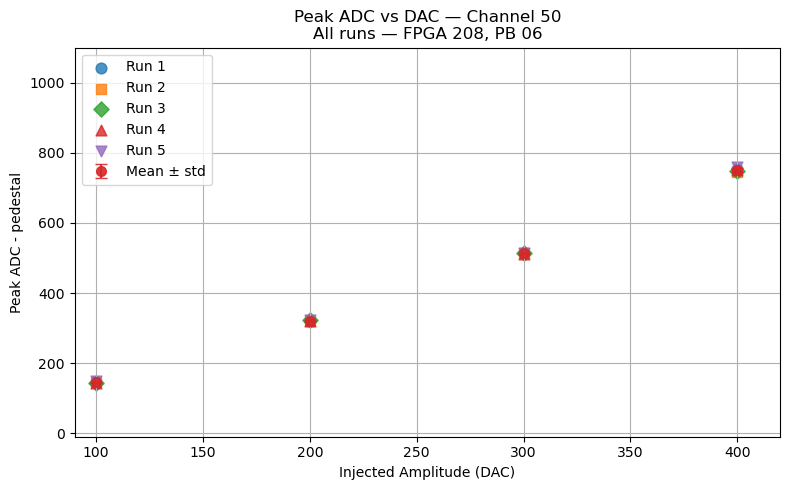


Statistics (mean/std per amplitude):


,Amplitude,mean,std
0,100,145.2,1.923538
1,200,321.2,1.923538
2,300,513.8,1.643168
3,400,751.6,5.983310


In [35]:
# ===== Choices =====
# "all" → show all runs, with different markers for each run
#   1–5 → show only that run
run_selection = "all"

print(f"Channel of interest: {channel_of_interest}")
print(f"Run selection: {run_selection}")

# Manual discarded list for this pair
manual_discarded_channels = manual_discarded_by_pair.get(
    (fpga_adc_mean, pb_adc_mean),
    set()
)
print("Manual discarded channels for this pair:", manual_discarded_channels)

# Check if channel is allowed
if (channel_of_interest in dead_channels or
    channel_of_interest in calibration_channels or
    channel_of_interest in notConnected_channels or
    channel_of_interest in manual_discarded_channels):
    print(f"⚠️ Channel {channel_of_interest} is discarded (dead/cal/notConnected/manual).")
else:

    # Fetch directory tree for this FPGA–PB pair
    try:
        all_dirs_pair = all_dirs[pair_key_mean]
    except KeyError:
        print(f"No all_dirs entry for pair {pair_key_mean}")
        all_dirs_pair = {}

    if not all_dirs_pair:
        print("No files available for this pair.")
    else:

        ped_i = pedestal_map_mean.get(channel_of_interest, fallback_pedestal)
        print(f"Using pedestal = {ped_i:.1f} ADC for channel {channel_of_interest}")

        # Markers for each run
        run_markers = ["o", "s", "D", "^", "v"]  # Run0, Run1, Run2, Run3, Run4

        # ----------------------------
        # CASE 1 ---------------------
        # Show ALL runs, separated
        # ----------------------------
        if run_selection == "all":

            fig, ax = plt.subplots(figsize=(8, 5))

            df_all = []   # to compute mean & std

            for run_idx in range(CONFIG["runs"]):  # 0..4
                run_marker = run_markers[run_idx]

                amps_this_run = []
                peaks_this_run = []

                # Loop over amplitudes
                for amplitude, runs_dict in all_dirs_pair.items():

                    if run_idx not in runs_dict:
                        continue
                    
                    run_file = runs_dict[run_idx]
                    if not os.path.exists(run_file):
                        continue

                    df = pd.read_csv(run_file)
                    df.columns = df.columns.str.strip()

                    # Filter one channel
                    channel_data = df[
                        (df["Channel"] == channel_of_interest) &
                        (~df["Phase"].isin([4, 6, 7]))
                    ]

                    if channel_data.empty:
                        continue

                    peak_val = channel_data["ADC"].max() - ped_i

                    amps_this_run.append(amplitude)
                    peaks_this_run.append(peak_val)

                    df_all.append([amplitude, peak_val])

                # ---- Plot this run ----
                if amps_this_run:
                    ax.scatter(
                        amps_this_run,
                        peaks_this_run,
                        label=f"Run {run_idx+1}",
                        marker=run_marker,
                        s=60,
                        alpha=0.8
                    )

            # Convert all data to df for computing mean & std
            df_all = pd.DataFrame(df_all, columns=["Amplitude", "PeakADC"])
            df_all = df_all.sort_values("Amplitude")

            stats = (
                df_all.groupby("Amplitude")["PeakADC"]
                .agg(["mean", "std"])
                .reset_index()
            )

            # Mean ± std
            ax.errorbar(
                stats["Amplitude"],
                stats["mean"],
                yerr=stats["std"],
                fmt="o",
                markersize=7,
                capsize=4,
                color="tab:red",
                ecolor="tab:red",
                label="Mean ± std",
                alpha=0.9
            )

            # Labels
            ax.set_title(
                f"Peak ADC vs DAC — Channel {channel_of_interest}\n"
                f"All runs — FPGA {fpga_adc_mean}, PB {pb_adc_mean}"
            )
            ax.set_xlabel("Injected Amplitude (DAC)")
            ax.set_ylabel("Peak ADC - pedestal")
            ax.set_xlim(min(CONFIG["amplitudes"]) - 10,
                        max(CONFIG["amplitudes"]) + 20)
            ax.set_ylim(-10, 1100)
            ax.grid(True)
            ax.legend()
            plt.tight_layout()
            plt.show()

            print("\nStatistics (mean/std per amplitude):")
            display(stats)

        # ----------------------------
        # CASE 2 ---------------------
        # Only one run selected
        # ----------------------------
        else:
            if not isinstance(run_selection, int) or not (1 <= run_selection <= CONFIG["runs"]):
                print(f"❌ Invalid run_selection={run_selection}. Must be 'all' or 1..{CONFIG['runs']}.")
            else:
                run_idx = run_selection - 1
                marker = run_markers[run_idx]

                amps = []
                peaks = []

                for amplitude, runs_dict in all_dirs_pair.items():
                    if run_idx not in runs_dict:
                        continue

                    run_file = runs_dict[run_idx]
                    if not os.path.exists(run_file):
                        continue

                    df = pd.read_csv(run_file)
                    df.columns = df.columns.str.strip()

                    channel_data = df[
                        (df["Channel"] == channel_of_interest) &
                        (~df["Phase"].isin([4, 6, 7]))
                    ]

                    if channel_data.empty:
                        continue

                    peak_val = channel_data["ADC"].max() - ped_i
                    amps.append(amplitude)
                    peaks.append(peak_val)

                # Plot for the single run
                fig, ax = plt.subplots(figsize=(8, 5))
                ax.scatter(
                    amps, peaks,
                    marker=marker,
                    s=80,
                    alpha=0.9,
                    label=f"Run {run_selection}"
                )
                ax.set_title(
                    f"Peak ADC vs DAC — Channel {channel_of_interest}\n"
                    f"Run {run_selection} — FPGA {fpga_adc_mean}, PB {pb_adc_mean}"
                )
                ax.set_xlabel("Injected Amplitude (DAC)")
                ax.set_ylabel("Peak ADC - pedestal")
                ax.set_xlim(min(CONFIG["amplitudes"]) - 10,
                            max(CONFIG["amplitudes"]) + 20)
                ax.set_ylim(-10, 1100)
                ax.grid(True)
                ax.legend()
                plt.tight_layout()
                plt.show()


In [22]:
# Define the channel to plot 
channel = 81
pedestals = 80
amplitudes, peaks = extract_peaks(all_dirs, channel, pedestals) 

amplitudes_array = np.array(amplitudes) 
#amplitudes_pC = (amplitudes_array - 193.03)/49 #pC

peaks_np = np.array(peaks)
means = peaks_np.reshape(-1,5).mean(axis=1)
std_dev = peaks_np.reshape(-1,5).std(axis=1)

# Linear regression 
slope, intercept, r_value, p_value, std_err = linregress(amplitudes_array, peaks) 

# Plotting 
colors = np.random.rand(25)

fig = plt.figure() 
plt.scatter(amplitudes_array, peaks, s=20, c=colors)
#plt.scatter(np.array([100, 200, 300, 400, 450]), means, s=20, c=colors) 
plt.errorbar(np.array([100, 200, 300, 400, 450]), means, yerr=std_dev, fmt='', linestyle="None", c='black')
plt.xlabel('Injected Amplitude (DAC)') 
plt.plot(amplitudes_array, slope*amplitudes_array + intercept, linestyle="--", color='red', label=f'R²={r_value**2:.4f}, m = {slope:.4f}, b = {intercept:.4f}') 
plt.ylabel('Peak Amplitude (ADC)') 
plt.title(f'Peak ADC vs Injected Amplitude (Channel {channel})') 
plt.ylim(0,1100)
plt.xlim(0,500)
plt.grid(True)
plt.legend()
#fig.savefig(f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/FPGA_{fpga}_pb{pb}/05_Peaks-Ch{channel}-{fpga}-pb{pb}.png')
plt.show() 


TypeError: stat: path should be string, bytes, os.PathLike or integer, not dict

[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]


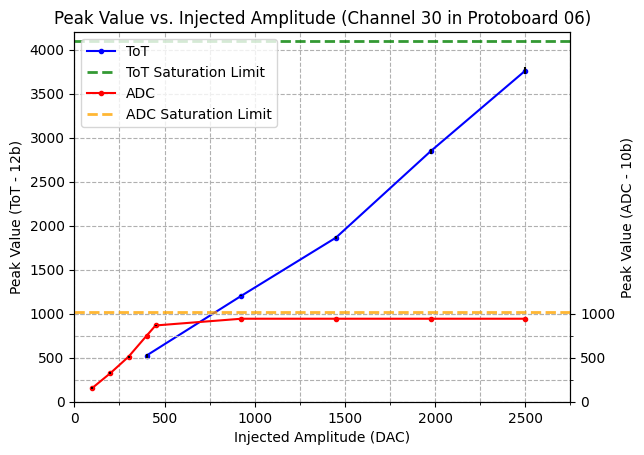

In [22]:
# Pedestal files for each protoboard
pedestal_file_path = {'01': '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/0dac/inj_adc_samples_208_pb01_76I_0_1.csv', 
                      '008': '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/0dac/inj_adc_samples_209_pb008_76I_0_1.csv',
                      '06': '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/0dac/inj_adc_samples_210_pb06_76I_0_1.csv'}

# Default pedestal values for each protoboard from the pedestal calibration files
default_pedestals = {'01': {79: 35, 83: 50, 115: 80, 116: 76, 117: 75},
                     '008': {},
                     '06': {}}

# Define the channel to plot 
channel = 30
pedestals = 80
amplitudes_tot, peaks_tot = extract_tot_mean(all_dirs_tot, channel, pedestals=0)
amplitudes_adc, peaks_adc = extract_peaks_pedestals_dynamic(all_dirs, channel, pb=pb_adc, pedestal_files=pedestal_file_path, default_pedestals=default_pedestals)
amplitudes_adc_over_450, peaks_adc_over_450 = extract_peaks(all_dirs_tot, channel, pedestals)

amplitudes_array = np.array(amplitudes_tot)
amplitudes_adc_array = np.array(amplitudes_adc) 
#amplitudes_pC = (amplitudes_array - 193.03)/49 #pC

peaks_tot_np = np.array(peaks_tot)
means_tot = peaks_tot_np.reshape(-1,5).mean(axis=1)
std_dev_tot = peaks_tot_np.reshape(-1,5).std(axis=1)

peaks_adc_np = np.array(peaks_adc)
means_adc = peaks_adc_np.reshape(-1,5).mean(axis=1)
std_dev_adc = peaks_adc_np.reshape(-1,5).std(axis=1)

peaks_adc_over_450_np = np.array(peaks_adc_over_450)
means_adc_over_450 = peaks_adc_over_450_np.reshape(-1,5).mean(axis=1)
std_dev_adc_over_450 = peaks_adc_over_450_np.reshape(-1,5).std(axis=1)

means_adc_all = np.concatenate((means_adc, means_adc_over_450[1:]), axis=0)
std_dev_adc_all = np.concatenate((std_dev_adc, std_dev_adc_over_450[1:]), axis=0)

# Linear regression 
#slope, intercept, r_value, p_value, std_err = linregress(amplitudes_array, peaks) 

# Plotting 
colors = np.random.rand(5)

fig, ax1 = plt.subplots()
line1, = ax1.plot(np.array([400, 925, 1450, 1975, 2500]), means_tot, c='blue', marker=".", label = 'ToT')
ax1.errorbar(np.array([400, 925, 1450, 1975, 2500]), means_tot, yerr=std_dev_tot, fmt='', linestyle="None", c='black')
ax1.set_xlabel('Injected Amplitude (DAC)') 
ax1.set_ylabel('Peak Value (ToT - 12b)') 
ax1.set_ylim(0,4200)
ax1.set_xlim(0,2750)
#ax1.grid(True)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))

ax1.grid(True, which='both', axis='both', linestyle = '--')

ax2 = ax1.twinx()

line2, = ax2.plot(np.array([100, 200, 300, 400, 450, 925, 1450, 1975, 2500]), means_adc_all, c='red', marker='.', label = 'ADC')
ax2.errorbar(np.array([100, 200, 300, 400, 450, 925, 1450, 1975, 2500]), means_adc_all, yerr=std_dev_adc_all, fmt='', linestyle="None", c='black')
ax2.set_ylabel('Peak Value (ADC - 10b)')
ax2.set_ylim(0,4200)

#ticks_to_show = range(0, 1024, 200)
#ax2.set_yticks(ticks_to_show)
#ax2.set_yticklabels(['' for _ in ticks_to_show])

minor_ticks = list(range(0,1024,250))
major_ticks = list(range(0,1024,500))

ax2.set_yticks(major_ticks)
ax2.set_yticks(minor_ticks, minor=True)

ax2.yaxis.grid(True, which='both', linestyle='--')

hline2 = ax2.axhline(y=1024, color='orange', linestyle='--', linewidth = 2, alpha=0.8, label = 'ADC Saturation Limit')
hline1 = ax1.axhline(y=4096, color='green', linestyle='--', linewidth = 2, alpha=0.8, label = 'ToT Saturation Limit')

plt.title(f'Peak Value vs. Injected Amplitude (Channel {channel} in Protoboard {pb_tot})')
lines = [line1, hline1, line2, hline2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
plt.show() 

#fig.savefig(f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/ADC_TOT_Range-Ch{channel}-{fpga_adc}-{fpga_tot}-pb{pb_tot}.png')


### Print ToT for channels

File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_209_pb01_76_400_1.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_209_pb01_76_400_2.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_209_pb01_76_400_3.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_209_pb01_76_400_4.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_209_pb01_76_400_5.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/925dac/inj_adc_samples_209_pb01_76_925_1.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/925dac/inj_adc_samples_209_pb01_76_925_2.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/925dac/inj_adc_sample

ValueError: Inputs must not be empty.

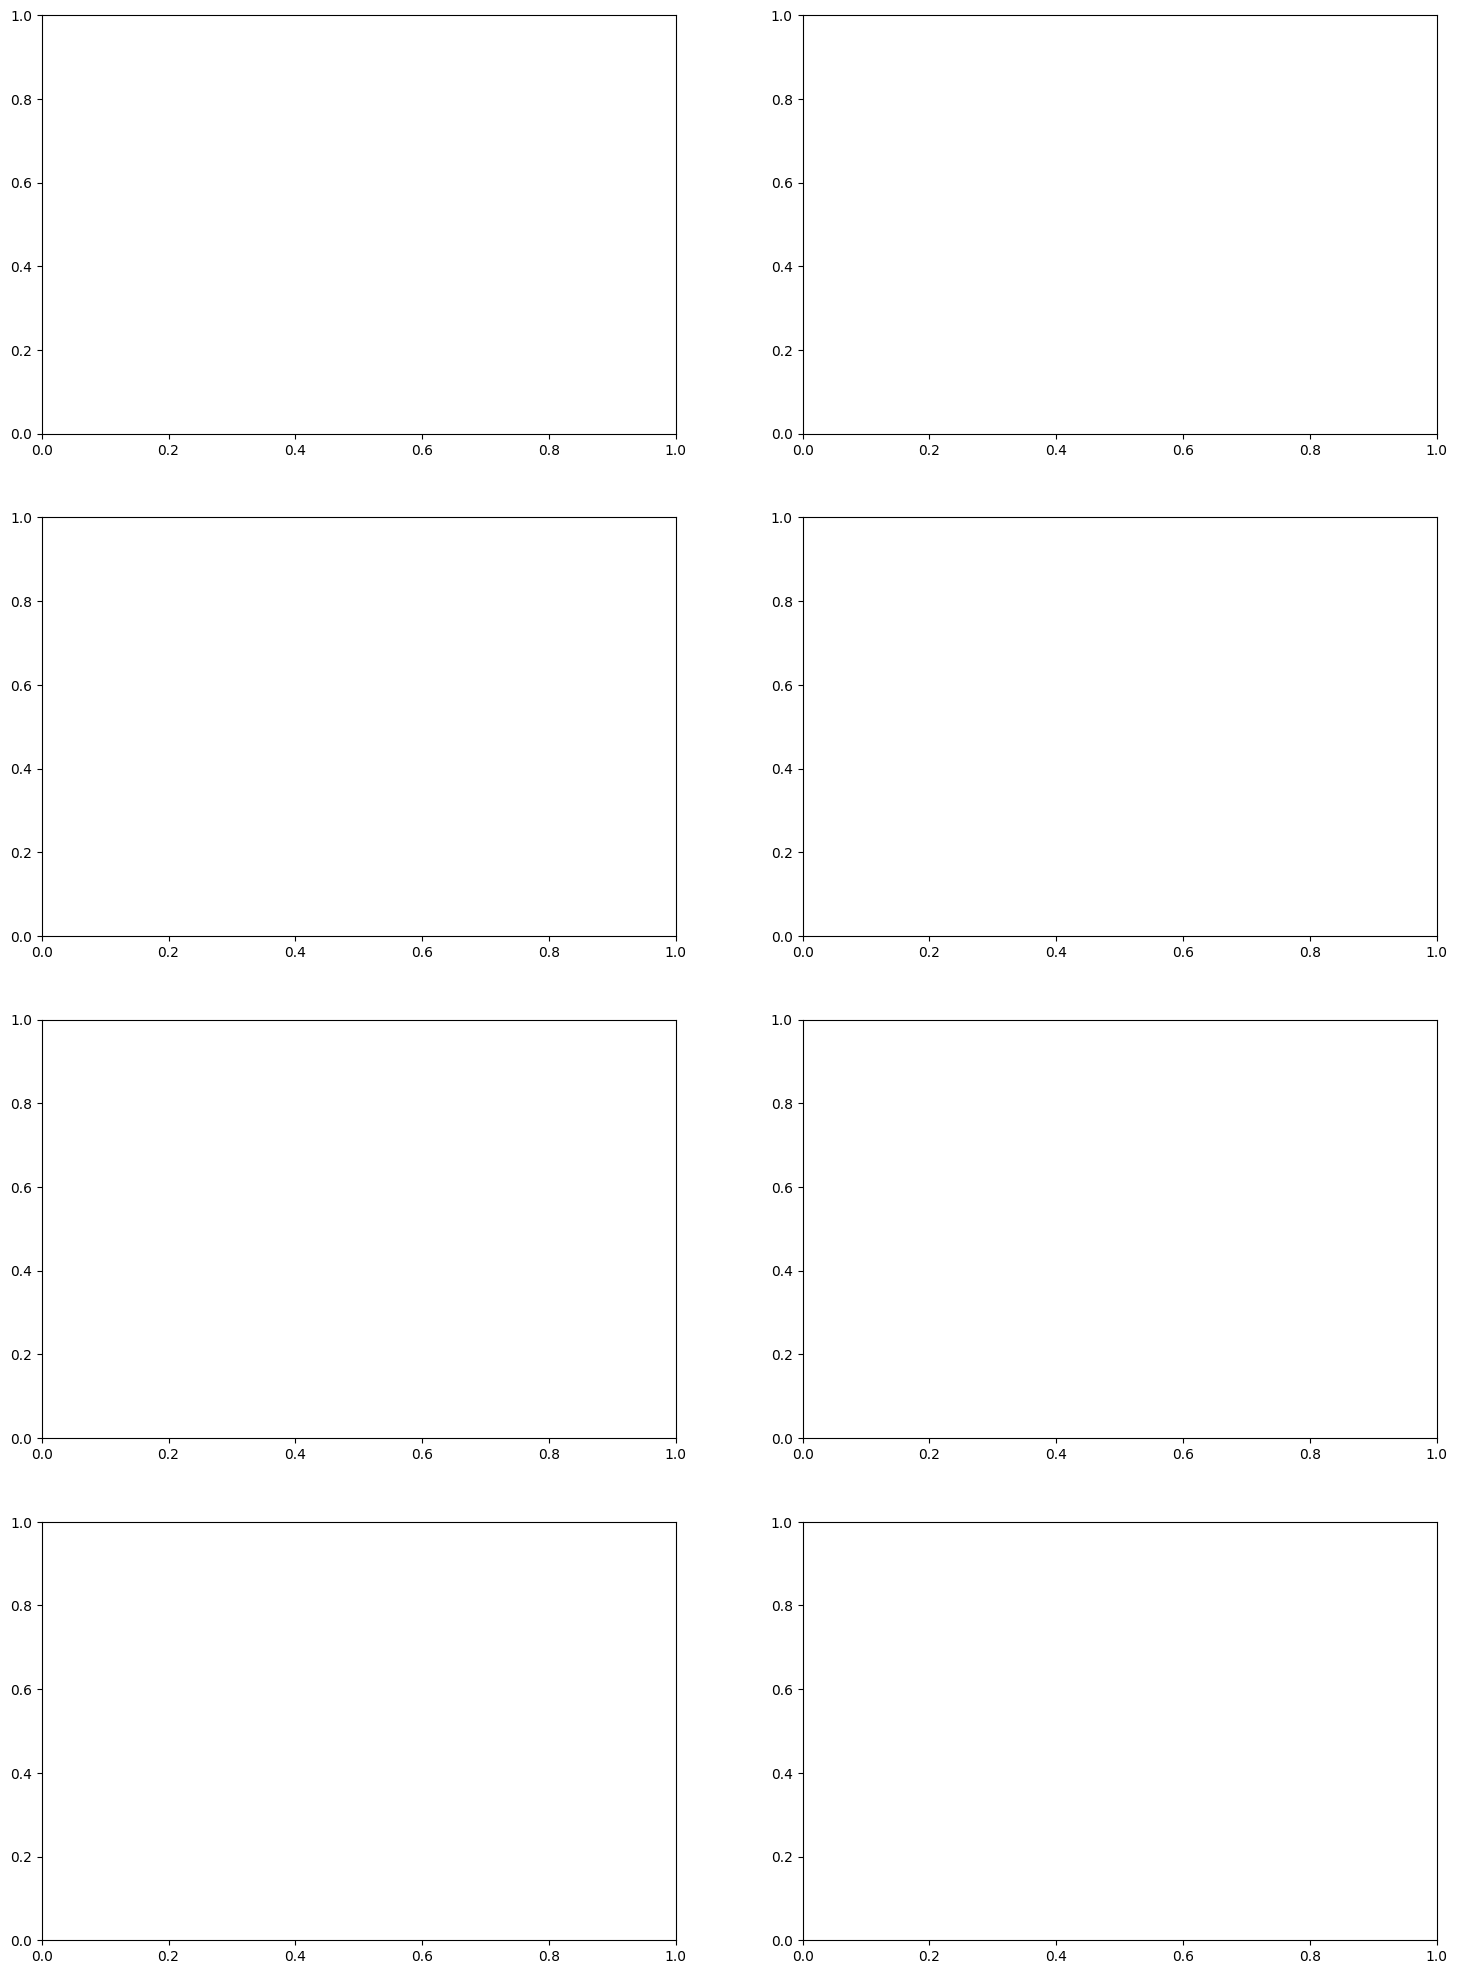

In [ ]:
#sns.set_theme()
plt.style.use('default')
# Create a figure with 4x2 subplots 
fig, axs = plt.subplots(4, 2, figsize=(18, 25)) 
axs = axs.flatten() 

# Marker styles to cycle through 
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h', 'X', '1', '2', '3', '4', '|'] 

line_colors = [
    "#e6194b",  # Red
    "#3cb44b",  # Green
    "#ffe119",  # Yellow
    "#4363d8",  # Blue
    "#f58231",  # Orange
    "#911eb4",  # Purple
    "#46f0f0",  # Cyan
    "#f032e6",  # Magenta
    "#bcf60c",  # Lime
    "#008080",  # Teal
    "#9a6324",  # Brown
    "#800000",  # Maroon
    "#808000",  # Olive
    "#000075",  # Navy
    "#a9a9a9",  # Dark Gray
    "#ff4500",  # Orange Red
    "#228b22",  # Forest Green
    "#1e90ff",  # Dodger Blue
    "#8b008b",  # Dark Magenta
]


# Define sets of channels to skip 
dead_channels = {0, 37, 38, 75, 76, 113, 114, 151}
calibration_channels = {19, 57, 95, 133}
notConnected_channels = {9, 18, 28, 47, 56, 66, 85, 94, 104, 123, 132, 142}

discarded_channels = {} # Protoboard 06
#discarded_channels = {} # Protoboard 01
#discarded_channels = {} # Protoboard 008

# Total groups 
num_groups = 8 
files_per_group = 19

colors = np.random.rand(19)

pedestals = 80

good_linearity_channels = []
bad_linearity_channels = []

# Loop over 8 groups 
for group_id in range(num_groups):
    j=1
    ax = axs[group_id]  # Select subplot 
    first_channel = group_id * files_per_group 
    last_channel = first_channel + files_per_group 
    marker_index = 0 
    j = 0

    for i in range(first_channel, last_channel): 
        if i in dead_channels or i in notConnected_channels or i in calibration_channels or i == 45: 
            #print(f"Skipping channel: {i}") 
            continue 

        amplitudes, peaks = extract_tot_mean(all_dirs_tot, i, pedestals) 

        # Converting amplitude to C 
        amplitudes_array = np.array(amplitudes) 
        #mplitudes_pC = amplitudes_array*2.0752/1000

        # Linear regression 
        slope, intercept, r_value, p_value, std_err = linregress(amplitudes_array, peaks) 

        # Compute the mean value in peaks per amplitude
        peaks_np = np.array(peaks)
        means = peaks_np.reshape(-1,5).mean(axis=1)
        std_dev = peaks_np.reshape(-1,5).std(axis=1)
        
        ax.scatter(amplitudes[4::5], means, s=20, c=line_colors[j % len(line_colors)], marker='o')
        #ax.scatter(amplitudes[4::5], means, s=20, marker='o', c=line_colors[j % len(line_colors)])
        #ax.scatter(amplitudes, peaks, s=20, marker='o', c=line_colors[j % len(line_colors)])
        ax.errorbar(amplitudes[4::5], means, yerr=std_dev, fmt='', linestyle="None", c=line_colors[j % len(line_colors)])
        #ax.errorbar(amplitudes[4::5], means, yerr=std_dev, fmt='', linestyle="None")
        # R²={r_value**2:.1f}
        ax.plot(amplitudes_array, slope*amplitudes_array + intercept, linestyle="--", color=line_colors[j % len(line_colors)], label=f'Ch={i}, R²={r_value**2:.4f}') 
        if r_value**2 >= 0.98:
            good_linearity_channels.append(i)
        else:
            bad_linearity_channels.append(i)
        
        j += 1
        marker_index += 1
        
    ax.set_title(f'Linearity on ToT from Connected channels ({first_channel}-{last_channel - 1}) on Protoboard {pb}') 
    ax.set_xlabel('Injected Amplitude (DAC)') 
    ax.set_ylabel('ToT value (12-bit)') 
    #ax.plot(amp, slope_ideal*amp + intercept_ideal, linestyle="-", color='black', label='Ideal Linearity')
    ax.set_ylim(-10, 4096)
    ax.set_xlim(0,3000)
    ax.grid(True) 
    ax.legend(fontsize='small',markerscale=1)
    #ax.legend()

# Adjust layout 
plt.tight_layout() 
plt.show()
#fig.savefig(f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/FPGA_{fpga}_pb{pb}/01_linearity_tot_pb{pb}.png')

# Output function to print channel lists
def print_channel_list(label, channels):
    print(f"\n{label} ({len(channels)} channels):")
    print(", ".join(str(int(c)) for c in sorted(channels)))
# Display the results
print_channel_list("🟢 Good Linearity Channels", good_linearity_channels)
print_channel_list("🔴 Bad Linearity Channels", bad_linearity_channels)

# Percerntage of good linearity channels
total_channels = 128
percentage_good = (len(good_linearity_channels) / total_channels) * 100 if total_channels > 0 else 0
print(f"\nPercentage of Good Linearity Channels: {percentage_good:.2f}%")


# ToT to ADC

Loaded 144 pedestal values for FPGA 208, PB 6


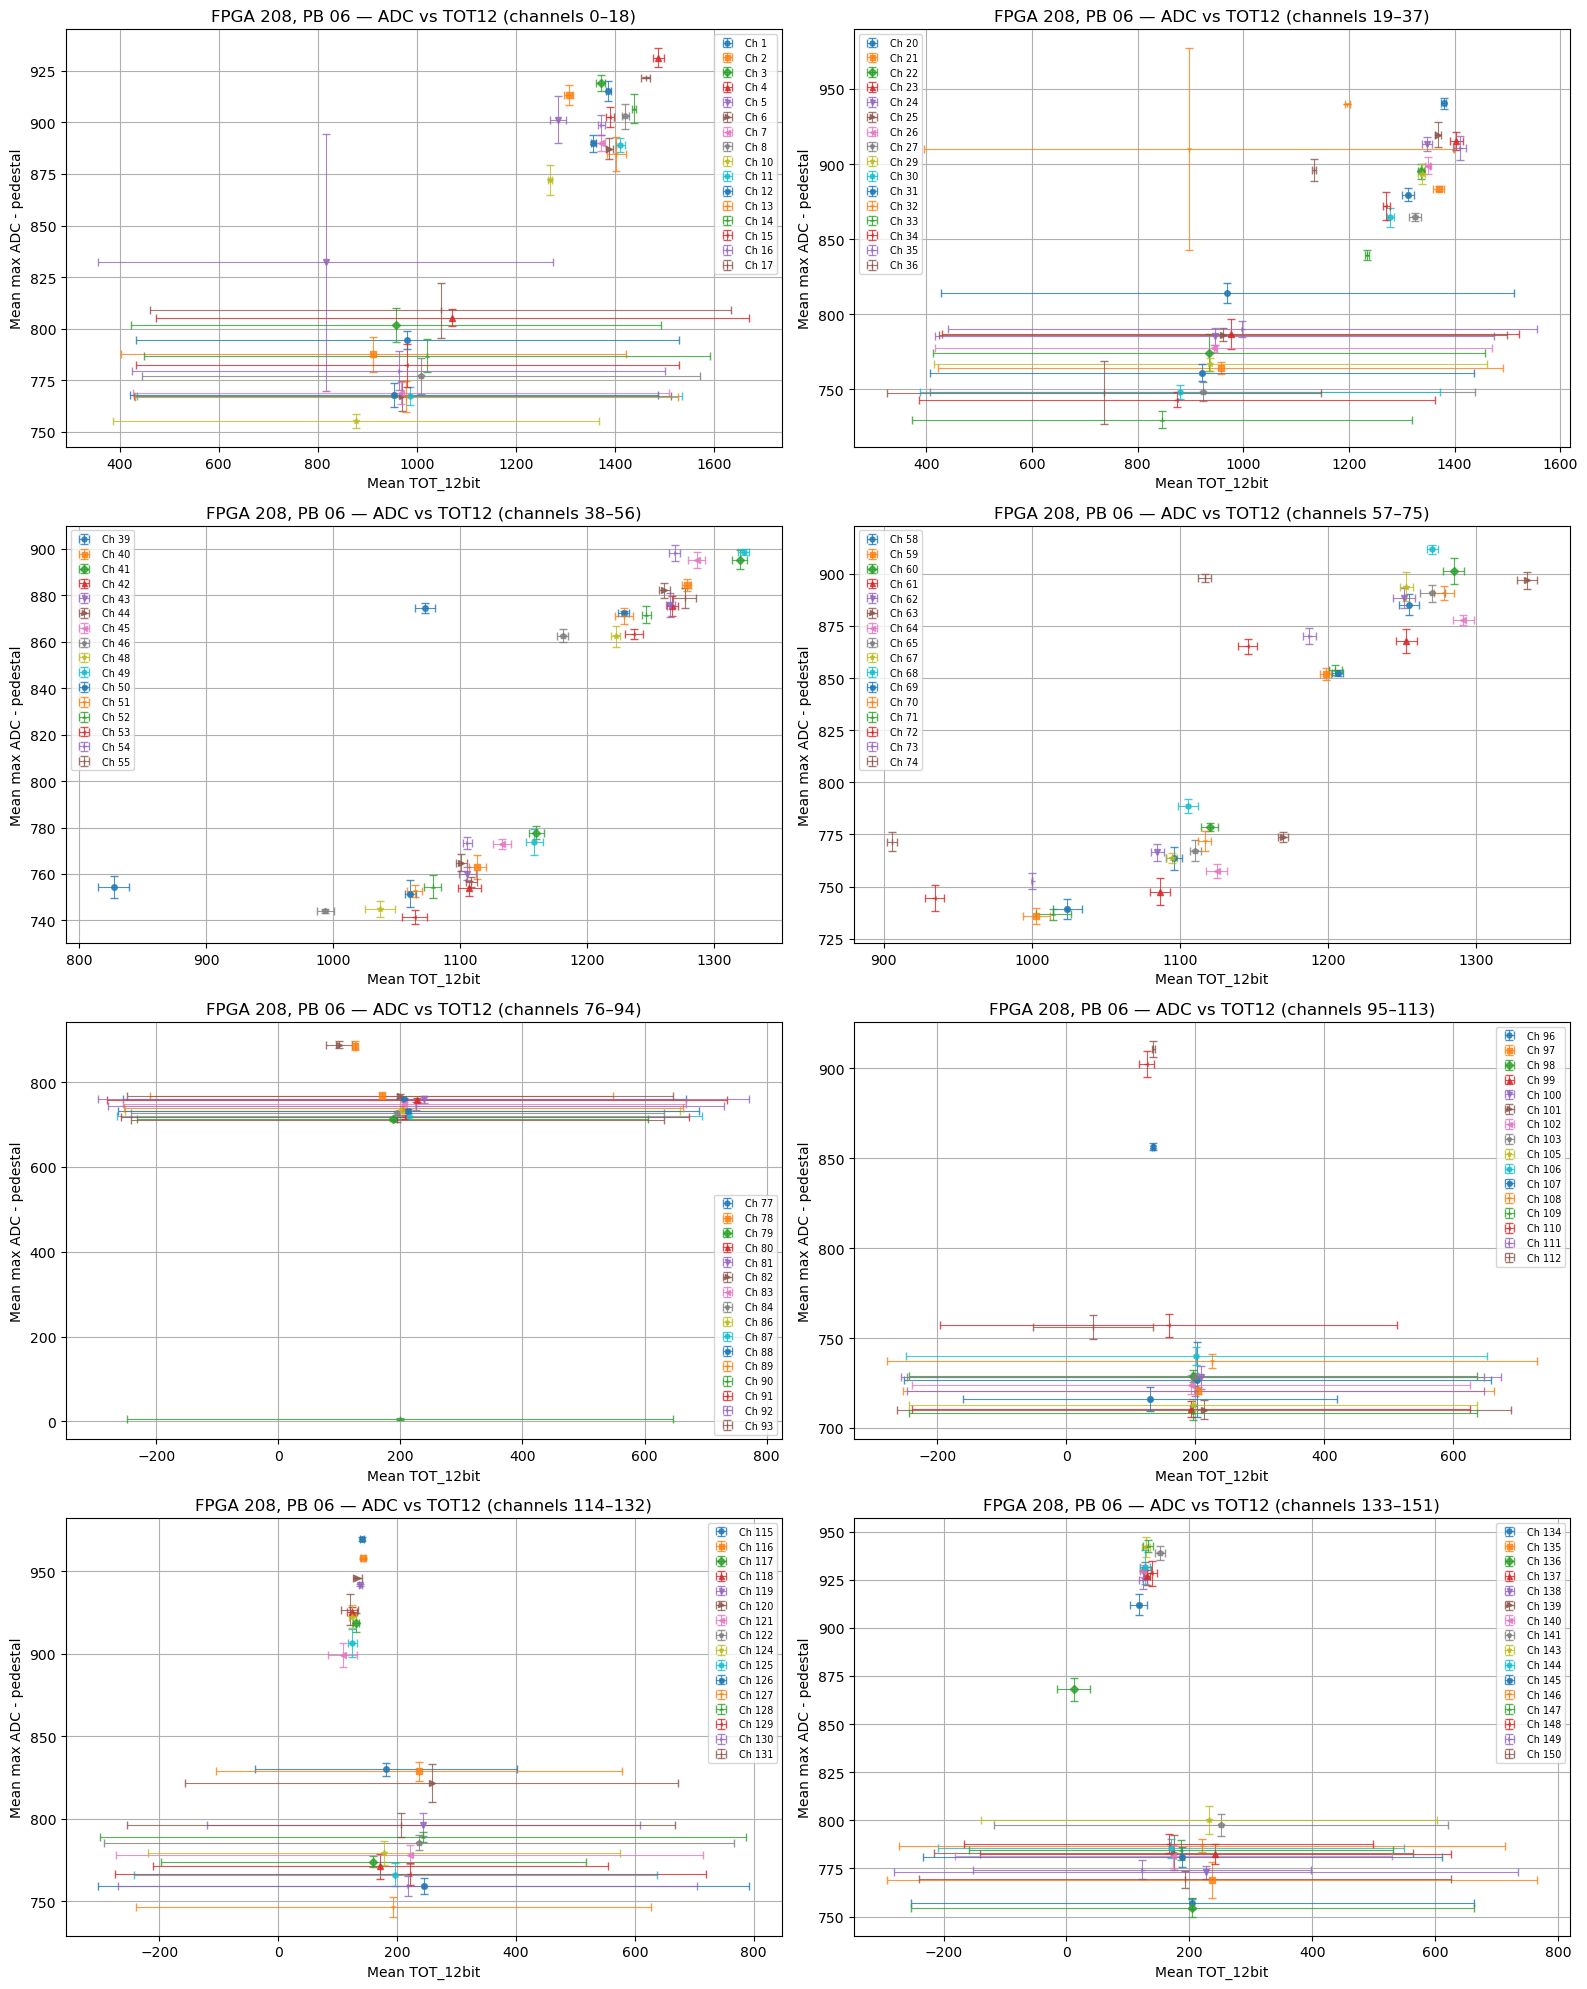

In [6]:
# ========= User choices =========
pair_id = 0                # 0 → (208,06), 1 → (209,008)
dac_values = [300, 400, 450]  # amplitudes to include in the ADC vs TOT12 plot

# ========= Get FPGA–PB pair from CONFIG =========
fpga_adc, pb_adc = CONFIG["fpga_pb_pairs"][pair_id]   # e.g. ("208", "06")
pair_key = f"fpga{fpga_adc}_pb{pb_adc}"

# ========= Load pedestal CSV and build channel → pedestal map =========
ped_df = pd.read_csv(PEDESTAL_CSV)

fpga_int = int(fpga_adc)
pb_int   = int(pb_adc)   # "06" → 6, "008" → 8

ped_sub = ped_df[(ped_df["FPGA"] == fpga_int) & (ped_df["PB"] == pb_int)]
pedestal_map = ped_sub.set_index("Channel")["HV"].to_dict()

print(f"Loaded {len(pedestal_map)} pedestal values for FPGA {fpga_int}, PB {pb_int}")

# ========= Grouping settings =========
num_groups = 8
files_per_group = 19

# ========= Figure =========
fig, axs = plt.subplots(4, 2, figsize=(16, 20))
axs = axs.flatten()

# ========= Loop over channel groups =========
for group_id in range(num_groups):
    ax = axs[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group
    marker_index = 0

    for channel in range(first_channel, last_channel):
        # Skip unwanted channels
        if (channel in dead_channels or
            channel in calibration_channels or
            channel in notConnected_channels):
            continue

        ped_i = pedestal_map.get(channel, fallback_pedestal)

        # Here we will collect per-run maxima for all DACs
        per_run_records = []

        # Loop over DAC values (amplitudes)
        for injected_amplitude in dac_values:
            # Get run_files for this amplitude
            try:
                run_files = all_dirs_tot[pair_key][injected_amplitude]   # dict: run_idx -> file_path
            except KeyError:
                # No files for this amplitude/pair
                continue

            for run_idx, file_path in run_files.items():
                if not os.path.exists(file_path):
                    print(f"File not found: {file_path}")
                    continue

                df = pd.read_csv(file_path)
                df.columns = df.columns.str.strip()

                # Filter by channel and remove unwanted phases
                channel_data = df[
                    (df['Channel'] == channel) &
                    (~df['Phase'].isin([4, 6, 7]))
                ]

                if channel_data.empty:
                    continue

                channel_data = channel_data.copy()
                # Subtract pedestal
                channel_data['ADC_corr'] = channel_data['ADC'] - ped_i

                adc_max_run = channel_data['ADC_corr'].max()
                tot_max_run = channel_data['TOT_12bit'].max()

                per_run_records.append({
                    "DAC": injected_amplitude,
                    "Run": run_idx,
                    "ADC_max": adc_max_run,
                    "TOT12_max": tot_max_run
                })

        # If we have no data for this channel at any DAC, skip
        if not per_run_records:
            continue

        # Convert to DataFrame
        ch_df = pd.DataFrame(per_run_records)

        # Remove cases where TOT is zero everywhere (no ToT info)
        if (ch_df["TOT12_max"] <= 0).all():
            continue

        # Compute mean and std per DAC
        stats = (
            ch_df
            .groupby("DAC")
            .agg(
                mean_ADC=("ADC_max", "mean"),
                std_ADC=("ADC_max", "std"),
                mean_TOT=("TOT12_max", "mean"),
                std_TOT=("TOT12_max", "std"),
            )
            .reset_index()
        )

        # Filter out DAC points with TOT = 0 (if any)
        stats = stats[stats["mean_TOT"] > 0]
        if stats.empty:
            continue

        # Plot mean ADC vs mean TOT with error bars
        ax.errorbar(
            stats["mean_TOT"],
            stats["mean_ADC"],
            xerr=stats["std_TOT"],
            yerr=stats["std_ADC"],
            fmt=markers[marker_index % len(markers)],
            markersize=4,
            capsize=3,
            elinewidth=0.8,
            label=f'Ch {channel}',
            alpha=0.8,
        )
        marker_index += 1

    ax.set_title(
        f'FPGA {fpga_adc}, PB {pb_adc} — ADC vs TOT12 '
        f'(channels {first_channel}–{last_channel - 1})'
    )
    ax.set_xlabel('Mean TOT_12bit')
    ax.set_ylabel('Mean max ADC - pedestal')
    ax.grid(True)
    ax.legend(fontsize='x-small', markerscale=0.9)

plt.tight_layout()
plt.show()

# Optional save:
output_dir = f'/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_adc}_pb{pb_adc}'
os.makedirs(output_dir, exist_ok=True)
# fig.savefig(os.path.join(output_dir, f'ADC_vs_TOT12_AllChannels_fpga{fpga_adc}-pb{pb_adc}.png'))
